In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("spark://127.0.0.1:7077") \
        .appName("mohit")\
        .config("spark.dynamicAllocation.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 3)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()


# RDD API
spark_context = spark.sparkContext

spark_context.setLogLevel("WARN")

In [6]:
from pyspark import SparkContext, SparkConf
rdd = spark_context.textFile("enlarged_extracted_info.csv")

# Show the first few lines of the RDD
#for line in rdd.take(5):
#    print(line)


In [7]:

# Split each line by comma and map to (Artist, Title) tuple
artist_song_rdd = rdd.map(lambda line: line.split(",")).map(lambda x: (x[1], x[2]))

# Group tuples by Artist and collect songs into a list
artist_songs_rdd = artist_song_rdd.groupByKey().mapValues(list)

# Collect and print the result
result = artist_songs_rdd.collect()
for artist, songs in result:
    print("Artist:", artist)
    print("Songs:", songs)


NameError: name 'rdd' is not defined

In [9]:
artist_song_duration_rdd = rdd.map(lambda line: line.split(",")).map(lambda x: (x[1], (x[2], x[5])))

# Group tuples by Artist and collect songs with durations into a list
artist_songs_duration_rdd = artist_song_duration_rdd.groupByKey().mapValues(list)

# Collect and print the result
result = artist_songs_duration_rdd.collect()
for artist, songs_duration in result:
    print("Artist:", artist)
    for song, duration in songs_duration:
        print("Song:", song, "- Duration:", duration)

Artist: Artist
Song: Title - Duration: Duration
Artist: Sonora Santanera
Song: Amor De Cabaret - Duration: 177.47546
Song: Estoy Pensando En Tí - Duration: 168.46322
Song: Cuando Quieres Tu - Duration: 167.70567
Artist: JennyAnyKind
Song: Young Boy Blues - Duration: 218.77506
Song: Didn't You Notice - Duration: 251.01016
Song: In A Village Square - Duration: 224.80934
Song: I'm On The Run - Duration: 326.79138
Artist: Bob Azzam
Song: Auguri Cha Cha - Duration: 191.84281
Song: Guarda Che Luna - Duration: 107.31057
Artist: Blue Rodeo
Song: Floating - Duration: 491.12771
Song: Mystic River - Duration: 251.402
Song: Up On That Cloud - Duration: 213.34159
Song: Million Miles - Duration: 543.97342
Song: Never Look Back - Duration: 199.05261
Artist: Tesla
Song: Caught In A Dream - Duration: 290.29832
Song: So What! - Duration: 228.98893
Song: The Way It Is - Duration: 390.66077
Song: Gettin' Better - Duration: 210.28526
Artist: lextrical
Song: Synthetic Dream - Duration: 165.69424
Artist: Ali

In [9]:
import time


# Start timing
start_time = time.time()



# Filter out the header row
header = rdd.first()
rdd = rdd.filter(lambda line: line != header)

# Split each line by comma and map to (Artist, (Duration, 1)) tuple
artist_duration_rdd = rdd.map(lambda line: line.split(",")).map(lambda x: (x[1], (float(x[5]), 1)))

# Reduce by key to sum up durations and count the number of songs per artist
artist_sum_count_rdd = artist_duration_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculate average duration for each artist
artist_avg_duration_rdd = artist_sum_count_rdd.mapValues(lambda x: x[0] / x[1])

# Collect and print the result
result = artist_avg_duration_rdd.collect()

end_time = time.time()
execution_time = end_time - start_time
print("Execution time using 2 cores 1 worker:", execution_time, "seconds")
for artist, avg_duration in result:
    print("Artist:", artist)
    print("Average Duration:", avg_duration)


spark.stop()



Execution time using 2 cores 1 worker: 25.372396230697632 seconds
Artist: L.A. Guns
Average Duration: 279.47056749999996
Artist: DJ Dips
Average Duration: 240.35219999999993
Artist: Grant Geissman
Average Duration: 325.74648666666656
Artist: Jazz Gillum
Average Duration: 168.1105674999996
Artist: Alexandre Desplat
Average Duration: 130.06757333333297
Artist: Tabu feat. Mitzib
Average Duration: 474.61832000000027
Artist: Avril - Remix By Ana Rago
Average Duration: 188.3946500000001
Artist: George Lopez
Average Duration: 258.2925166666663
Artist: Weezer
Average Duration: 182.2645799999998
Artist: Olov Johansson_ Catriona Mckay
Average Duration: 469.68117999999987
Artist: Aaron Watson
Average Duration: 215.28335666666635
Artist: Abysmal Dawn
Average Duration: 250.3570999999998
Artist: Sylvia Patricia
Average Duration: 259.34322000000003
Artist: The Red Telephone
Average Duration: 273.5538299999999
Artist: Mötley Crüe
Average Duration: 252.70811999999967
Artist: BigElf
Average Duration: 26

In [20]:
import time
start_time = time.time()

header = rdd.first()
rdd = rdd.filter(lambda line: line != header)

# Split each line by comma and extract unique artists
unique_artists_rdd = rdd.map(lambda line: line.split(",")[1]).distinct()

# Count the number of unique artists
num_unique_artists = unique_artists_rdd.count()

# Print the result
print("Number of unique artists:", num_unique_artists)

Number of unique artists: 3837


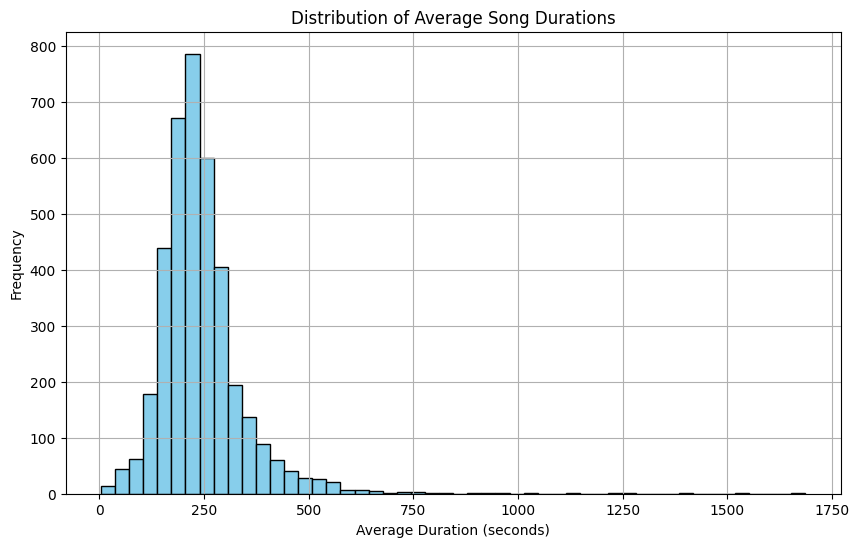

In [8]:
import matplotlib.pyplot as plt

# Convert result RDD to Python dictionary
result_dict = dict(result)

# Extract average durations
avg_durations = list(result_dict.values())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_durations, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Average Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Average Song Durations')
plt.grid(True)
plt.savefig('song average.png')
plt.show()

In [11]:
spark.stop()

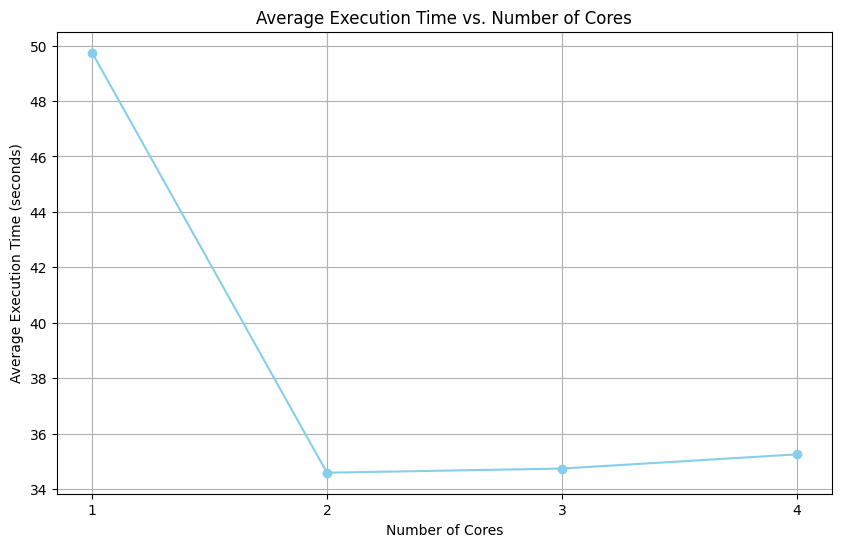

In [10]:
import matplotlib.pyplot as plt

# Execution times for different configurations
cores = [1, 2, 3, 4]
execution_times = [
    [50.38927388191223, 50.194148778915405, 48.64591073989868],
    [35.88343858718872, 33.92104911804199, 33.955681800842285],
    [35.81295323371887, 34.48569846153259, 33.91249918937683],
    [36.4241361618042, 35.020265340805054, 34.3]
]

# Calculate average execution time for each configuration
avg_execution_times = [sum(times) / len(times) for times in execution_times]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(cores, avg_execution_times, marker='o', color='skyblue')
plt.xlabel('Number of Cores')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Execution Time vs. Number of Cores')
plt.grid(True)
plt.xticks(cores)
plt.savefig('average_execution_time_plot.png')
plt.show()

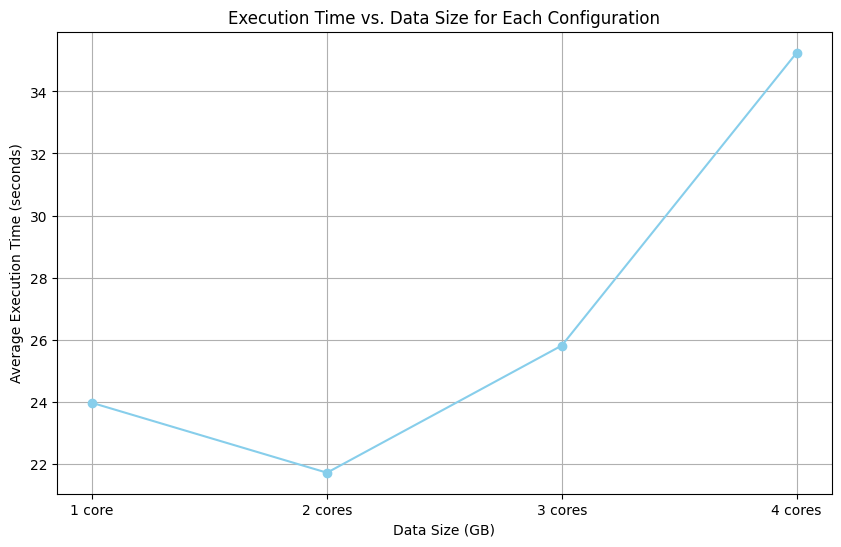

In [13]:
import matplotlib.pyplot as plt

# Data
configurations = ['1 core', '2 cores', '3 cores', '4 cores']
data_sizes = [0.75, 1.0, 1.25, 1.5]  # Data sizes in GB
execution_times = [
    [23.62445306777954, 24.236403226852417, 24.02145767211914],
    [22.641847133636475, 21.05816912651062, 21.42667555809021],
    [25.732017517089844, 26.323925256729126, 25.372396230697632],
    [36.4241361618042, 35.020265340805054, 34.3]
]

# Calculate average execution time for each configuration
avg_execution_times = [sum(times) / len(times) for times in execution_times]

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot the average execution time against the data size for each configuration
plt.plot(data_sizes, avg_execution_times, marker='o', color='skyblue', linestyle='-')

plt.xlabel('Data Size (GB)')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Execution Time vs. Data Size for Each Configuration')
plt.xticks(data_sizes, configurations)
plt.grid(True)

plt.savefig('weak_scaling.png')
plt.show()


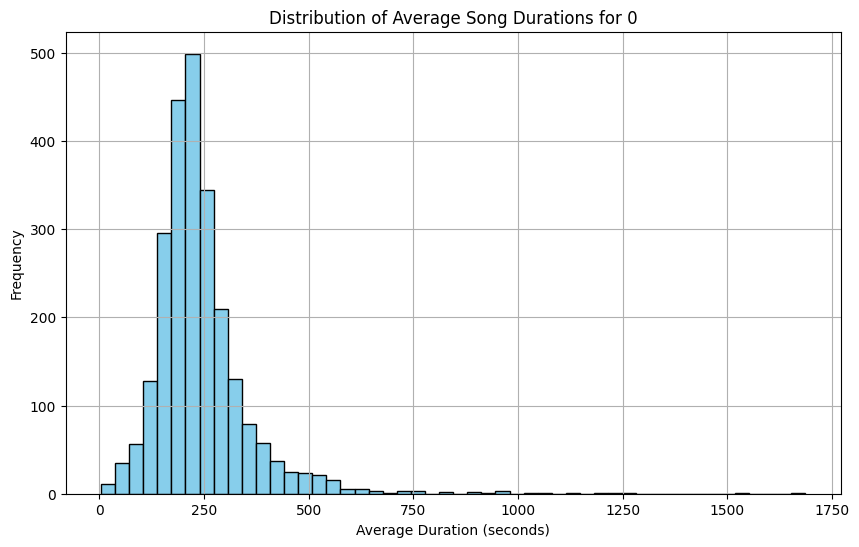

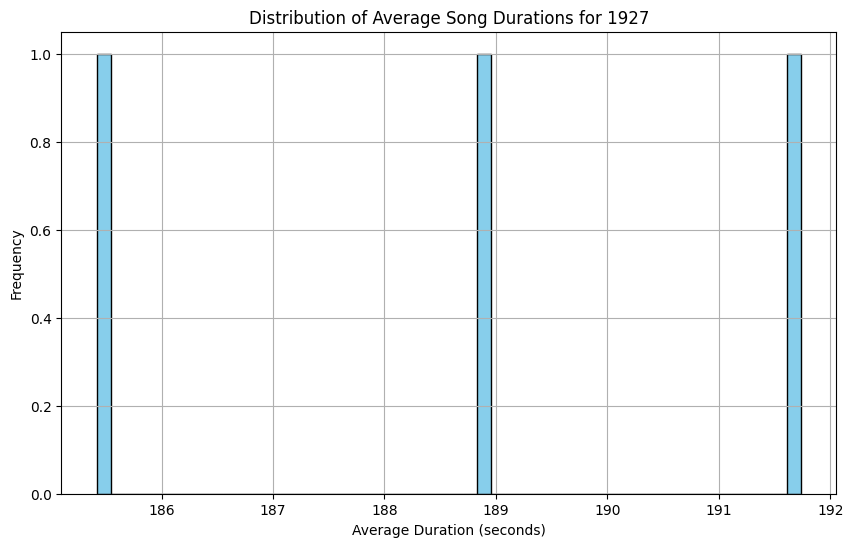

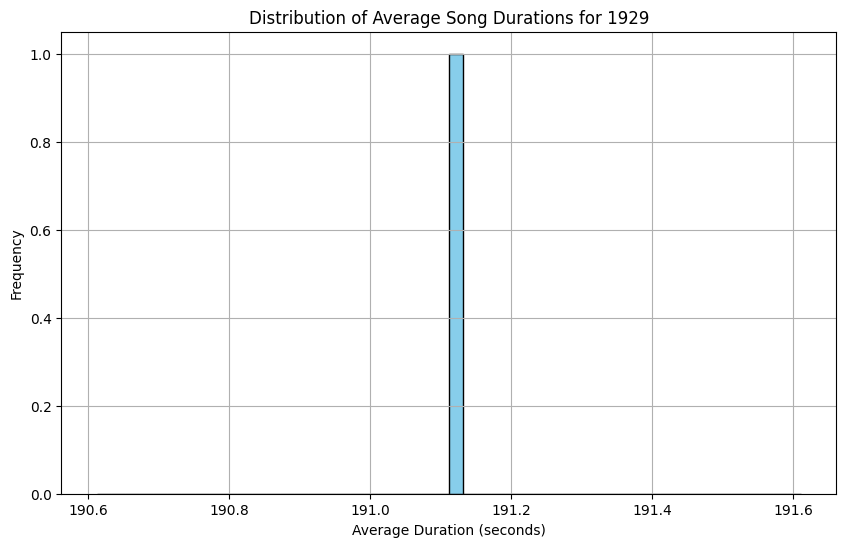

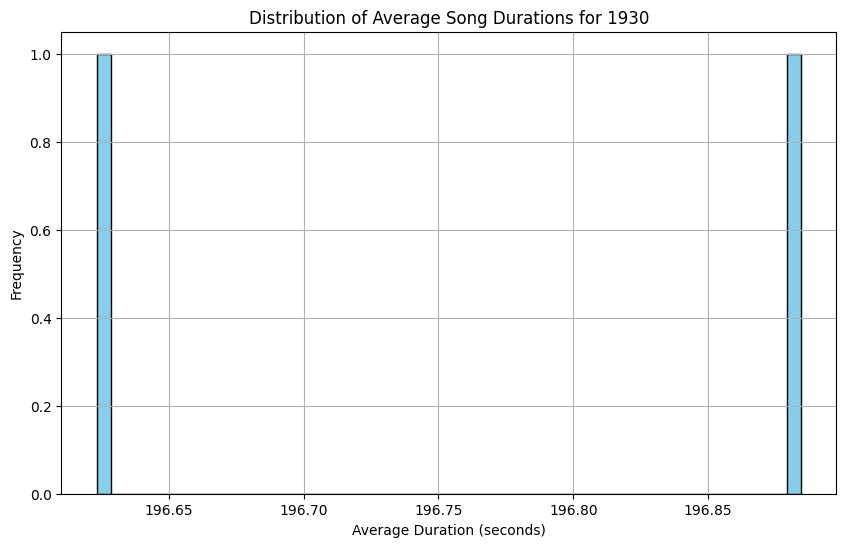

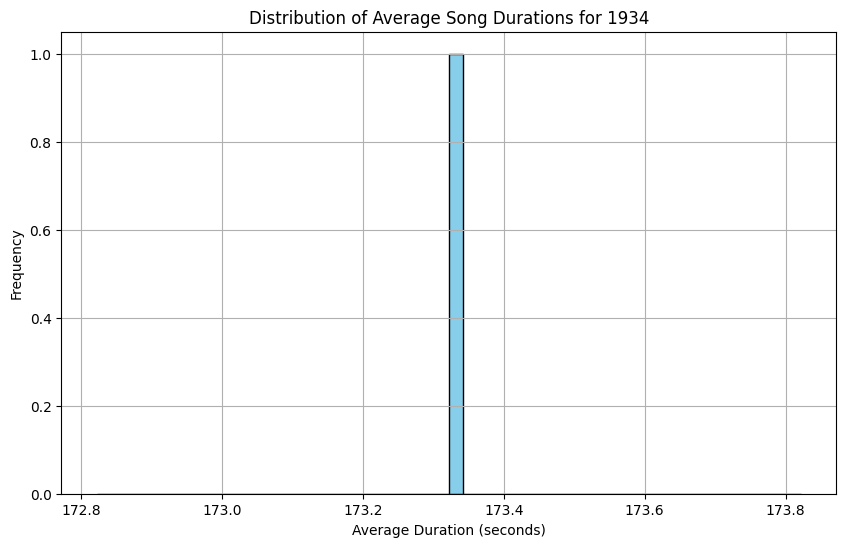

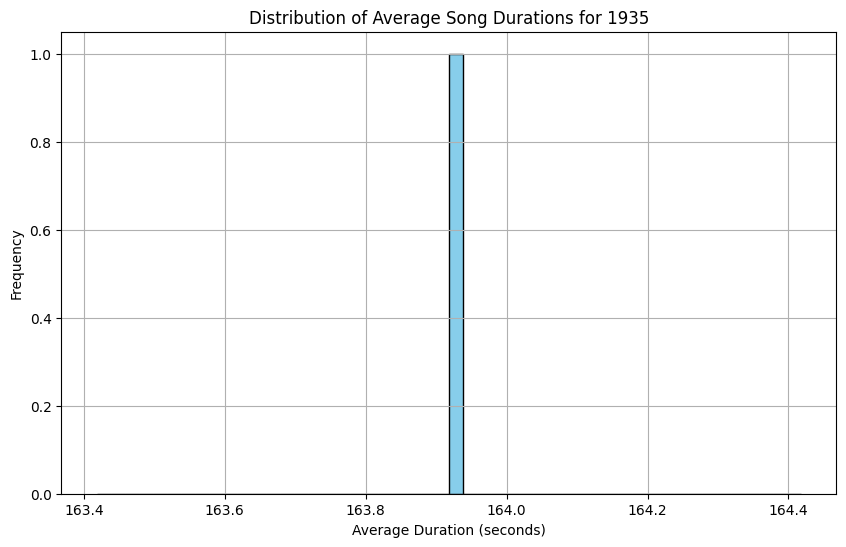

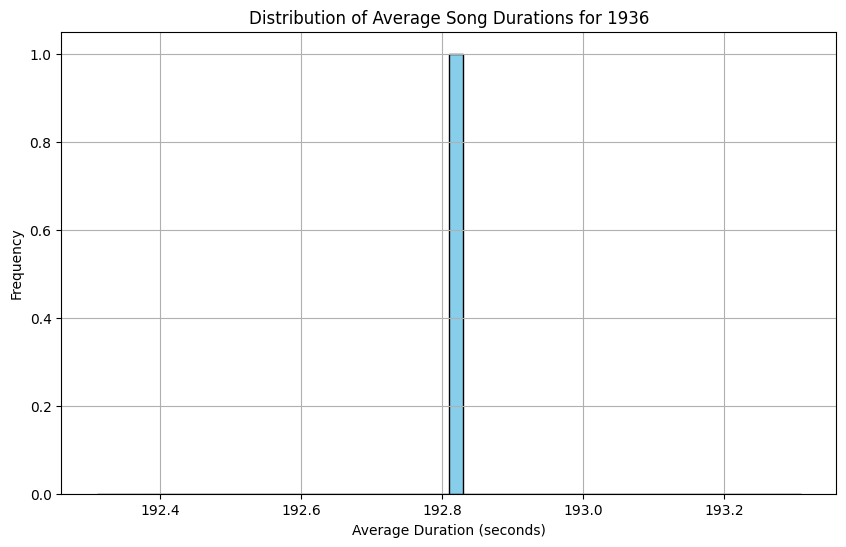

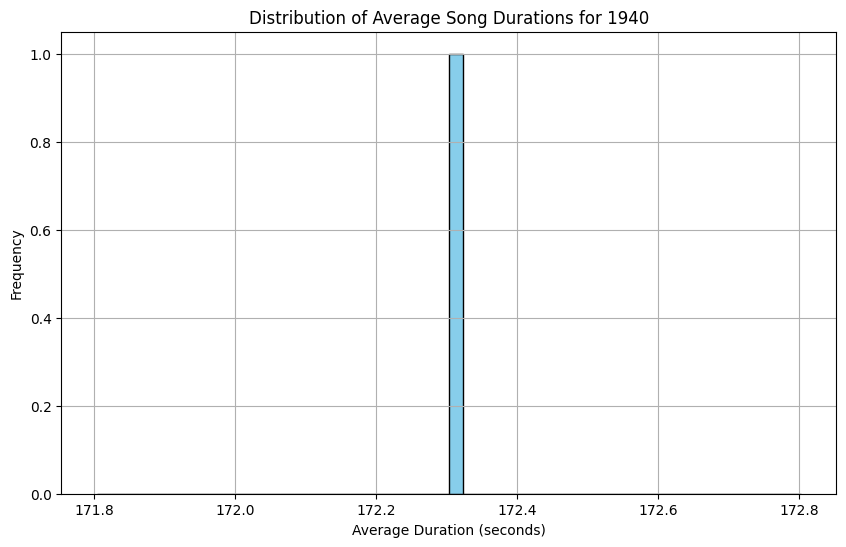

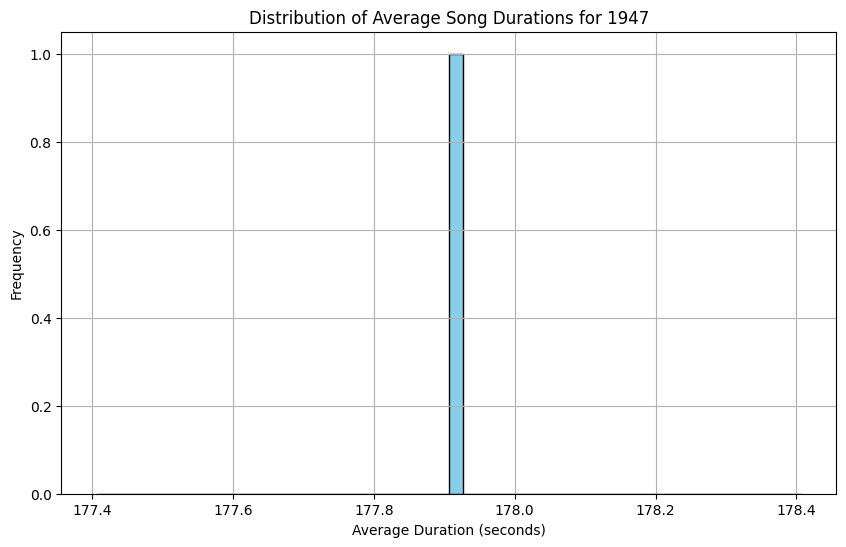

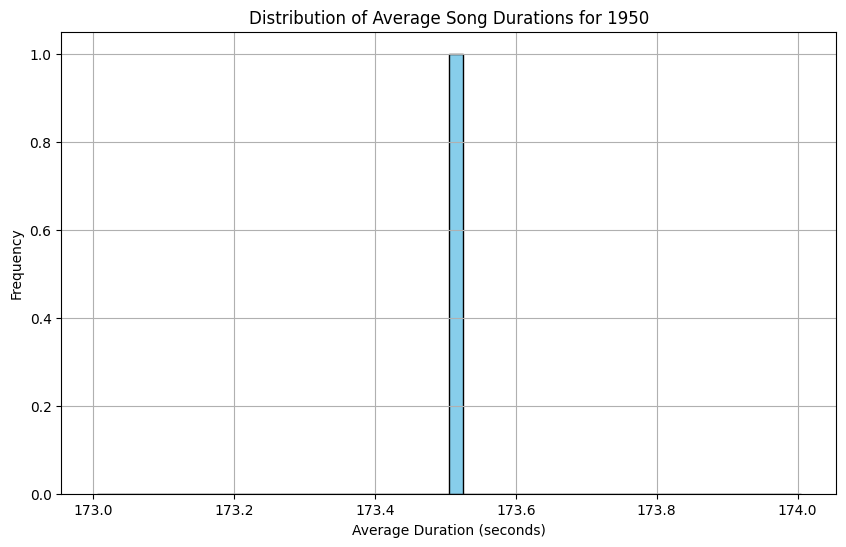

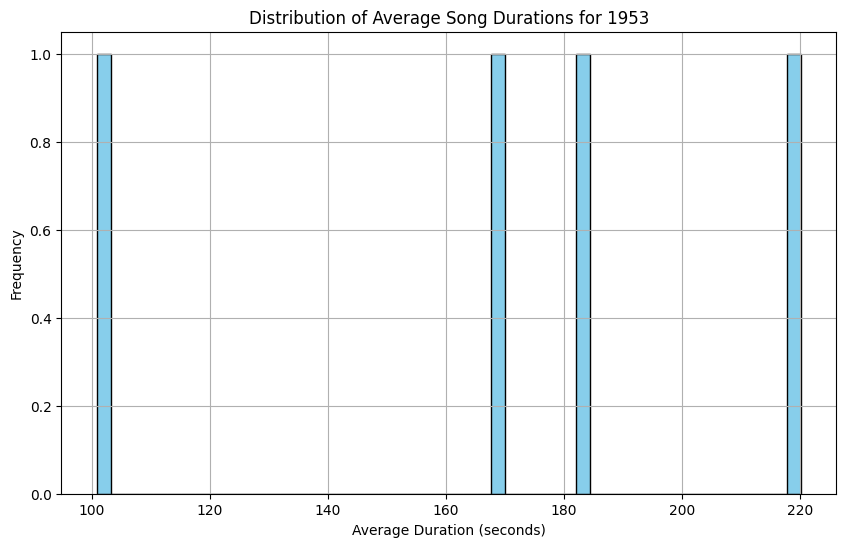

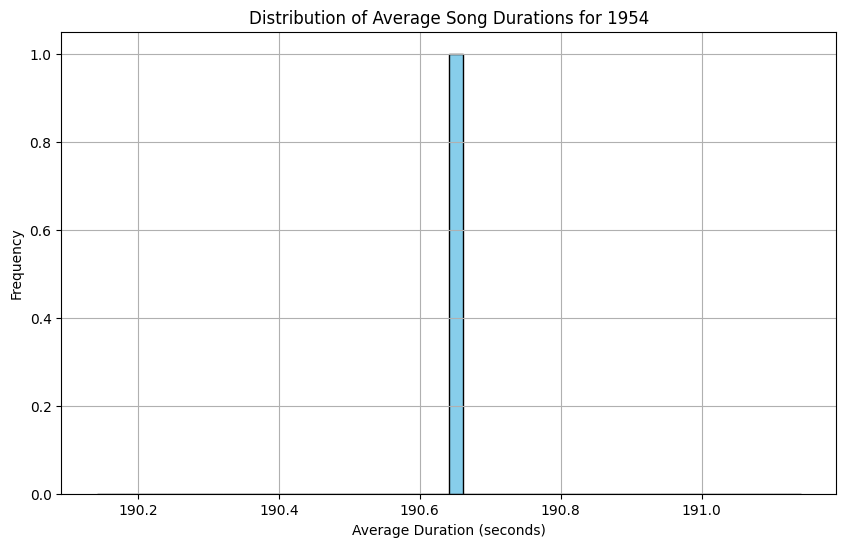

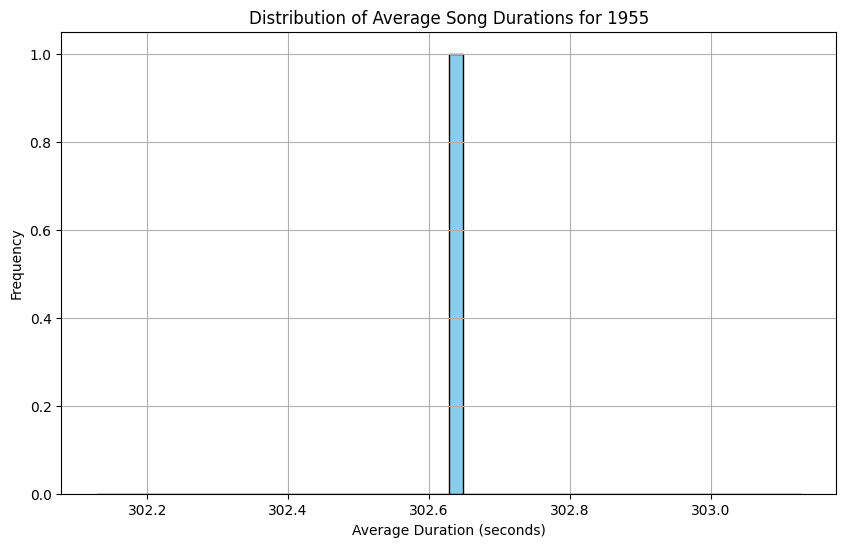

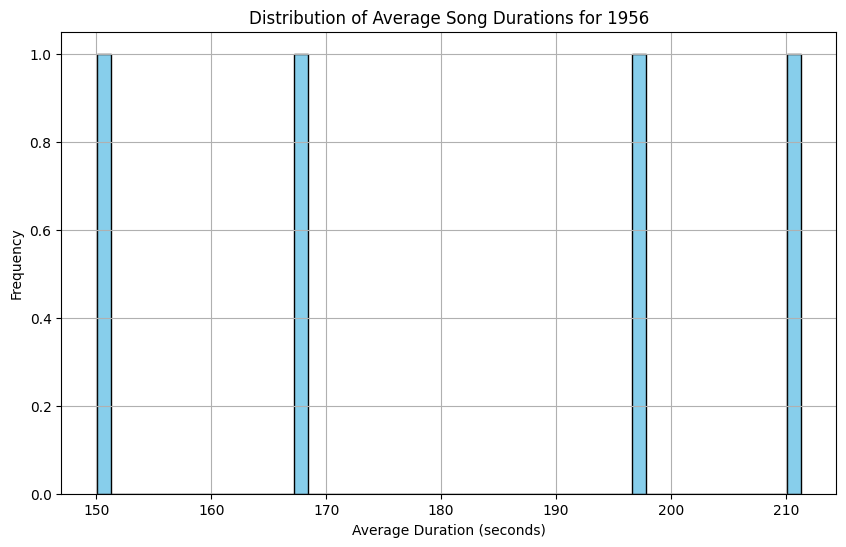

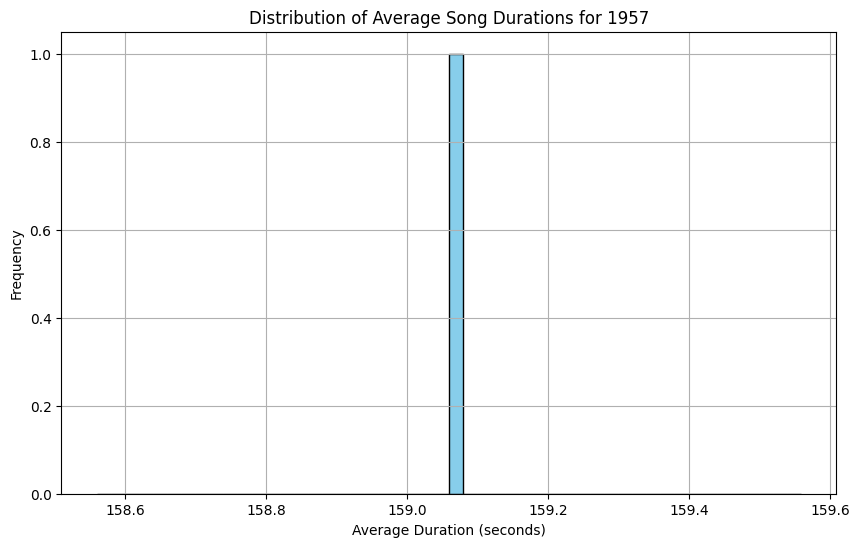

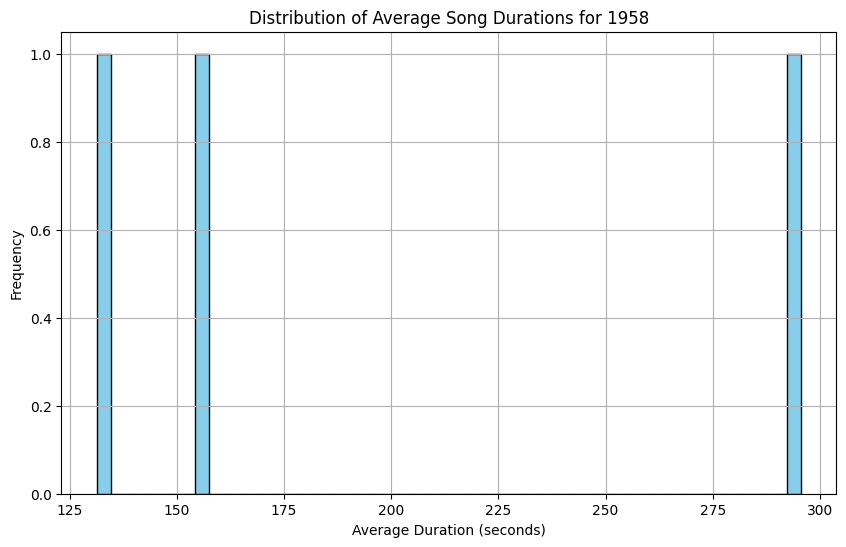

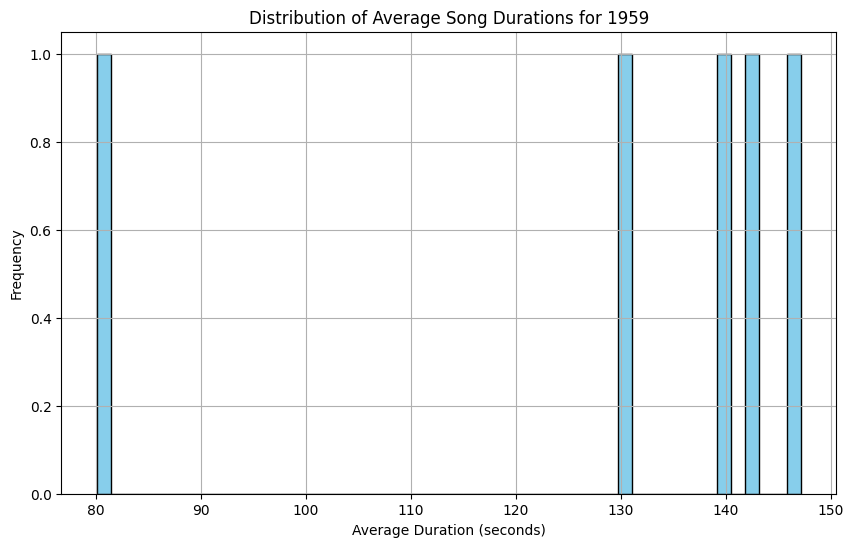

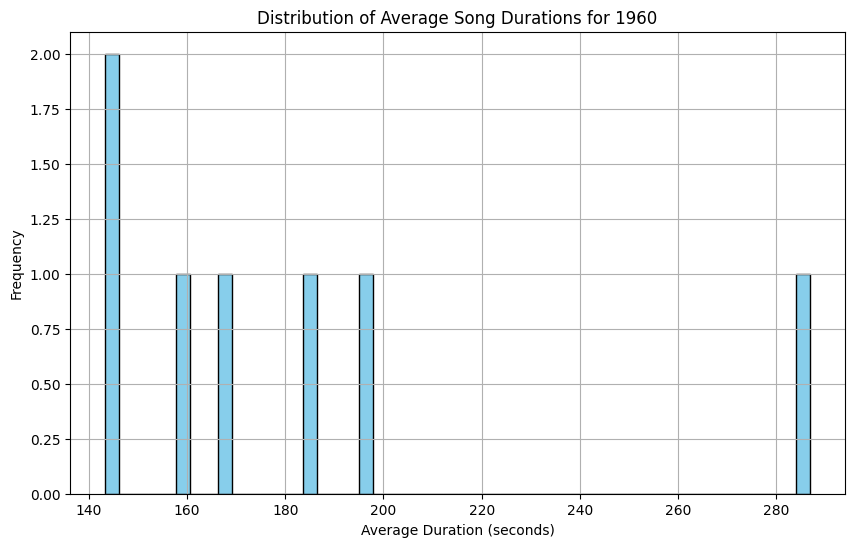

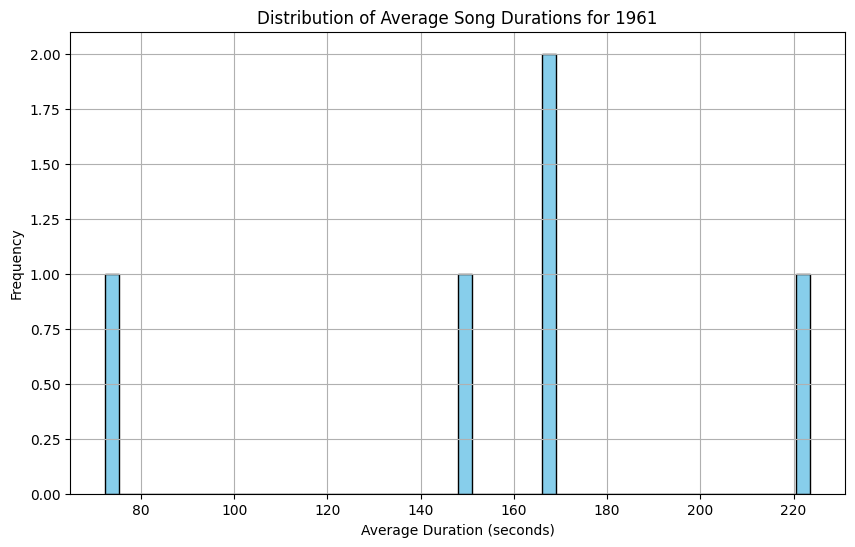

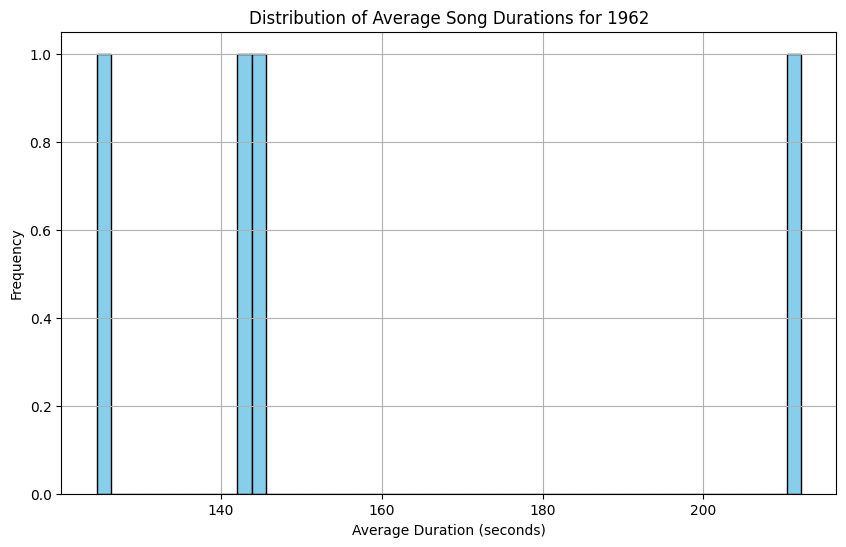

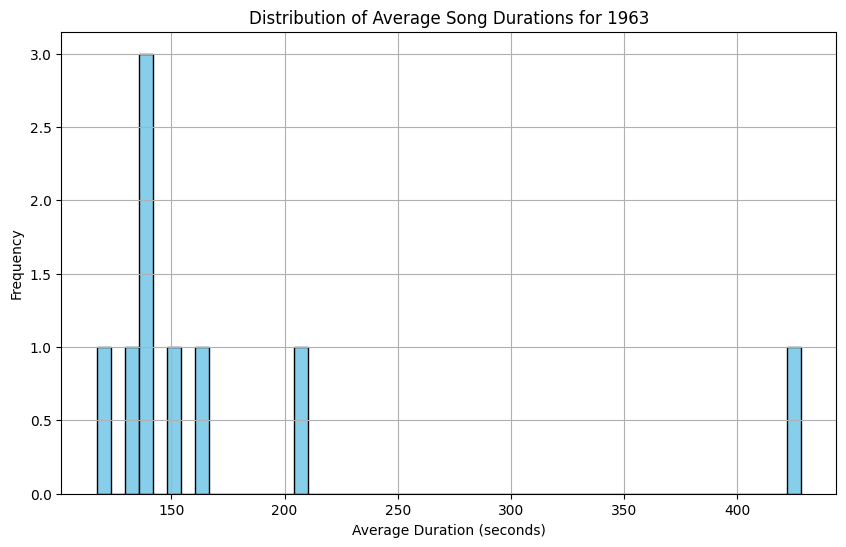

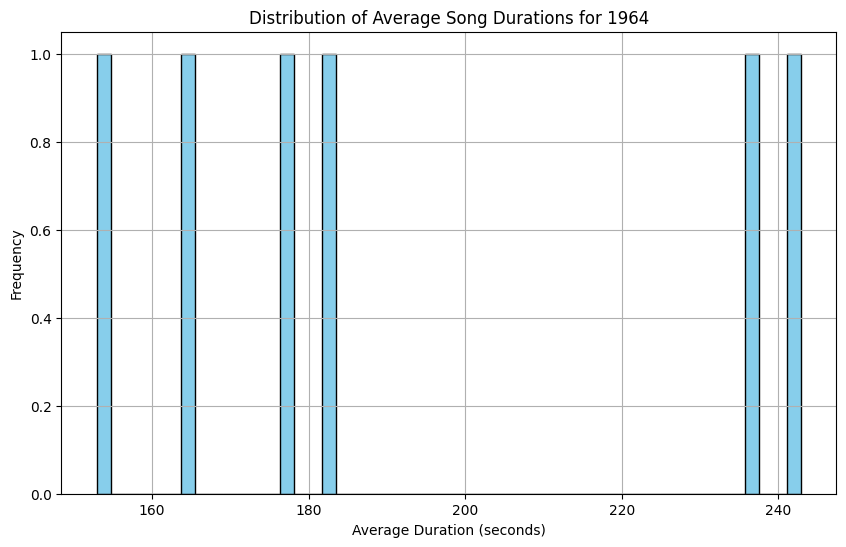

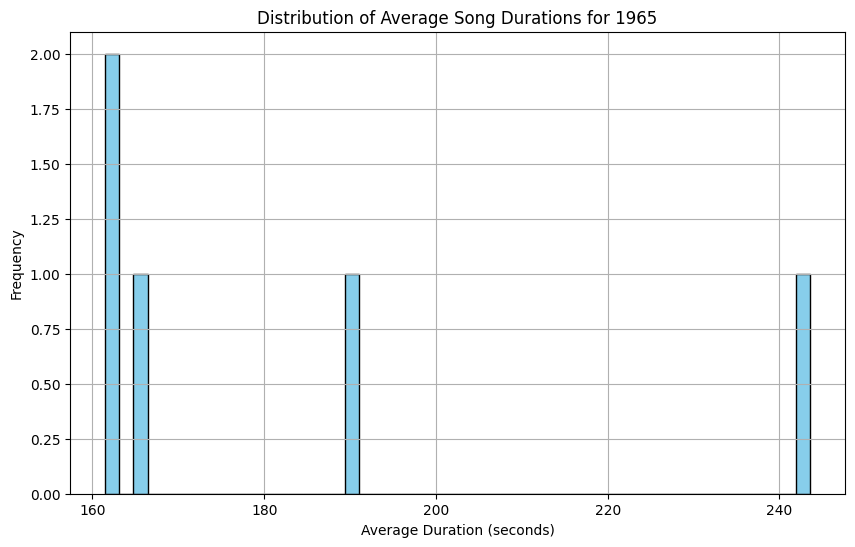

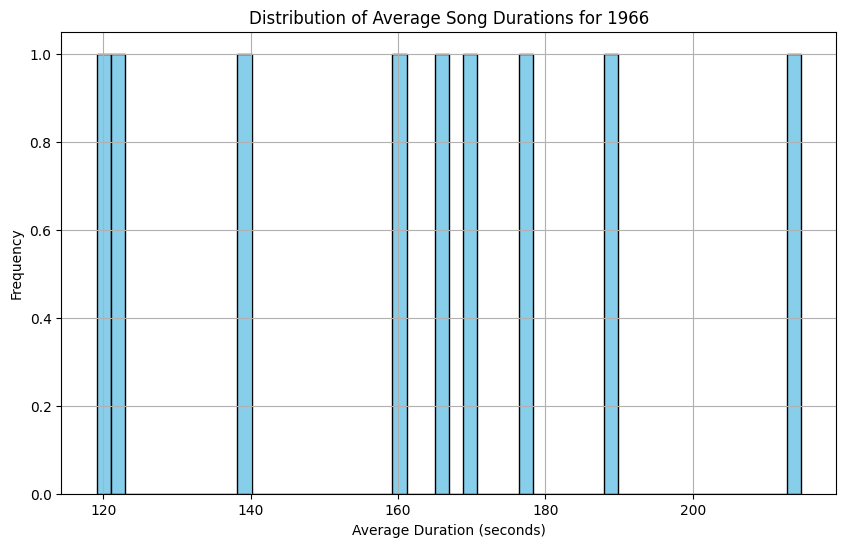

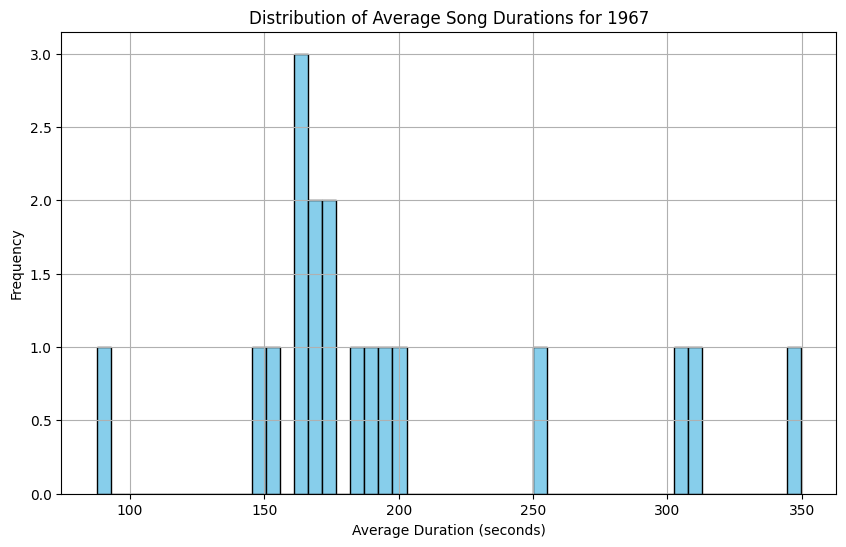

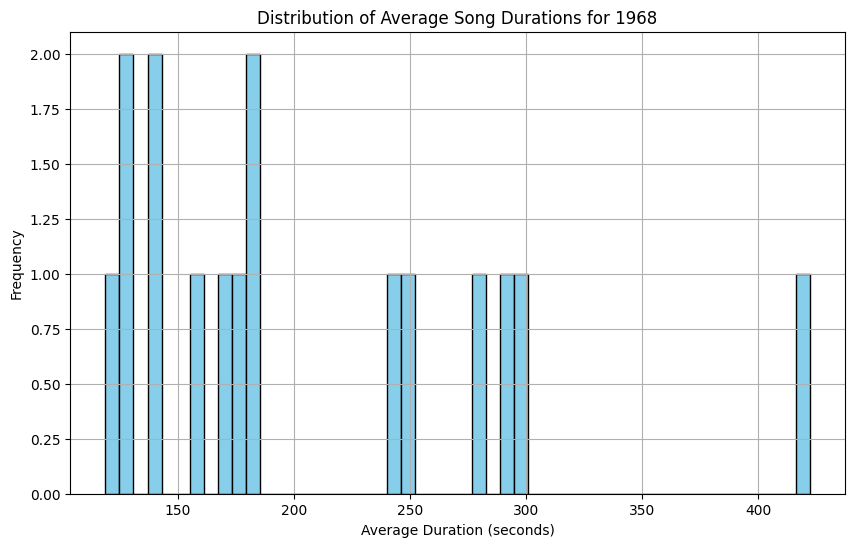

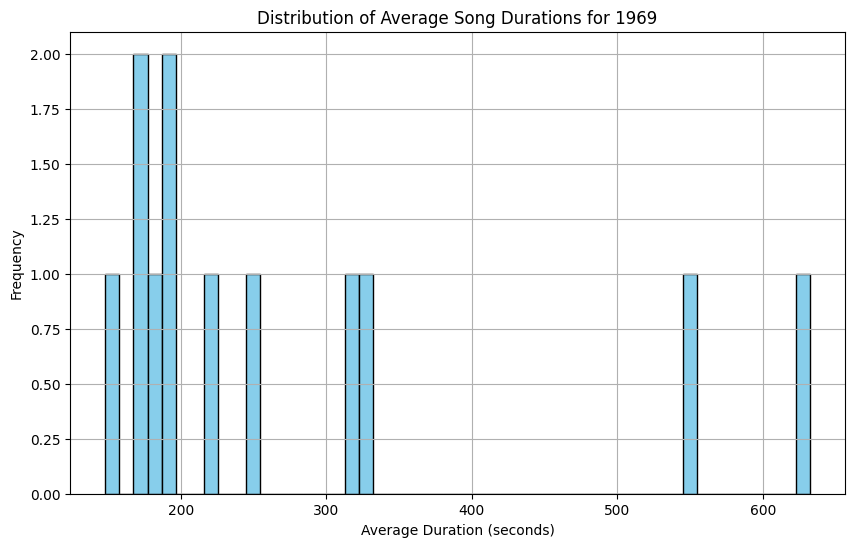

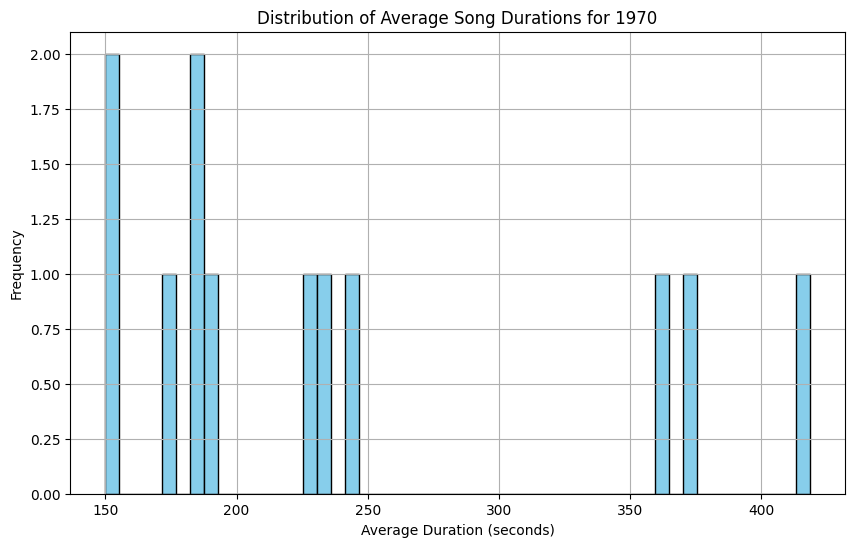

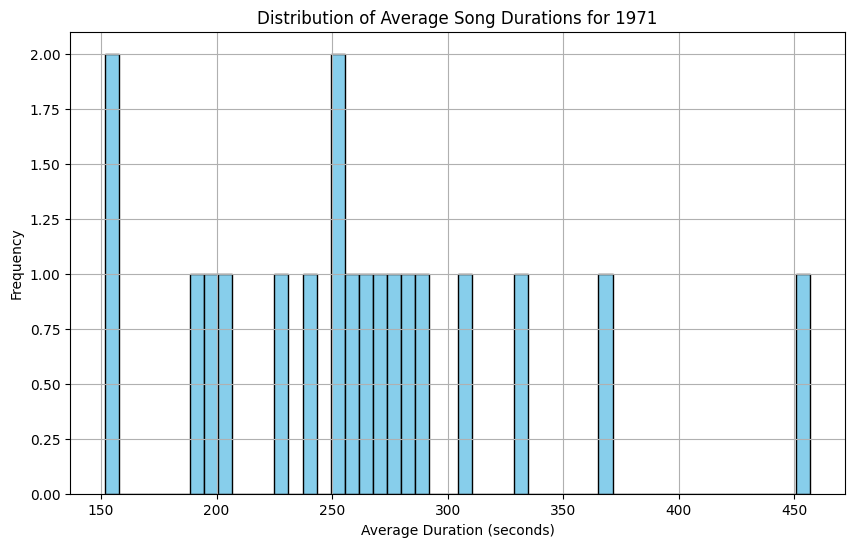

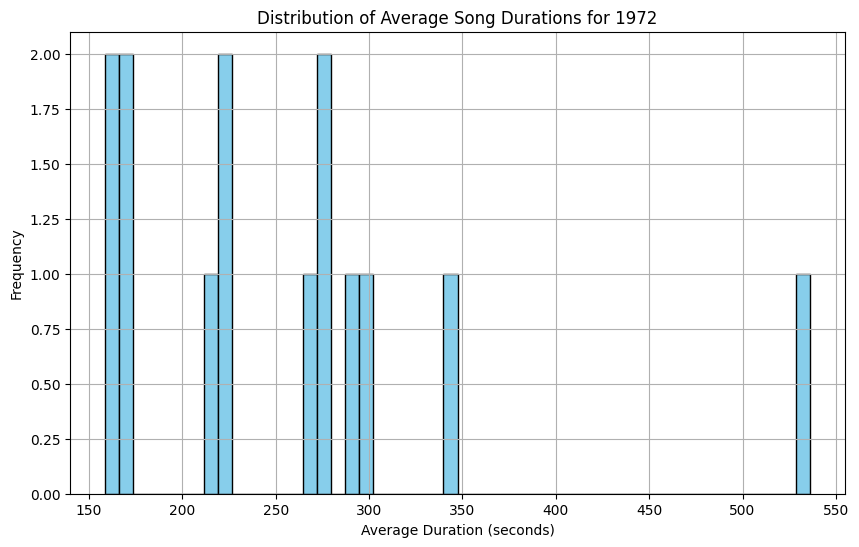

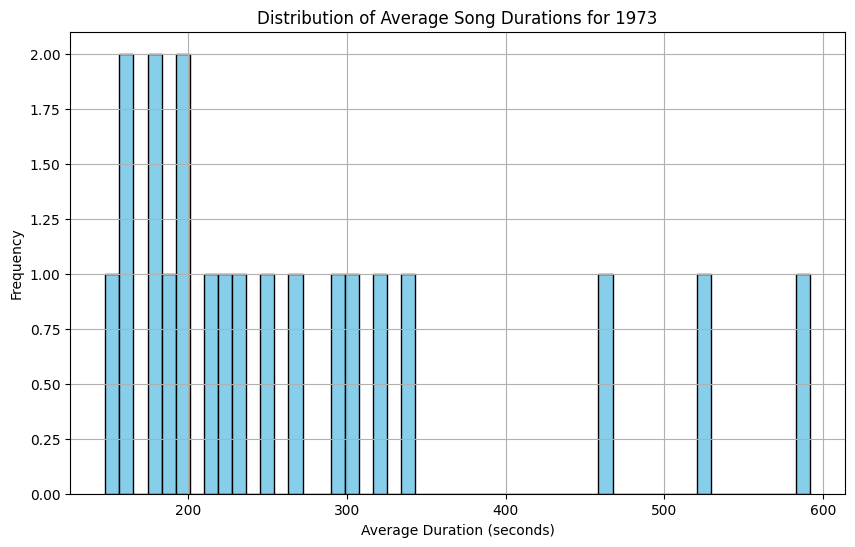

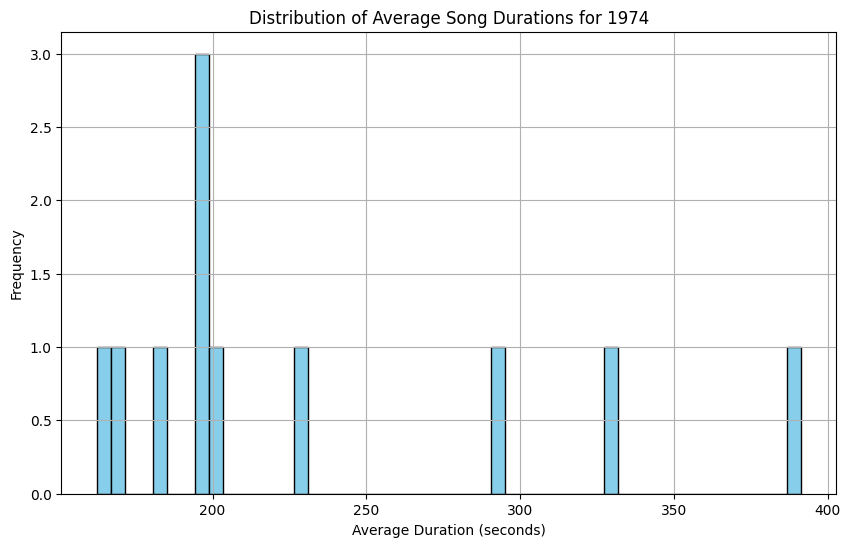

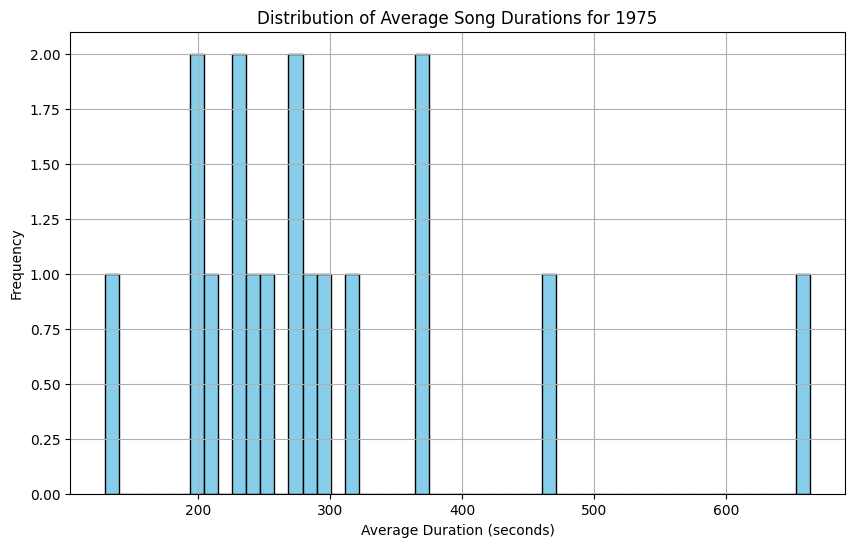

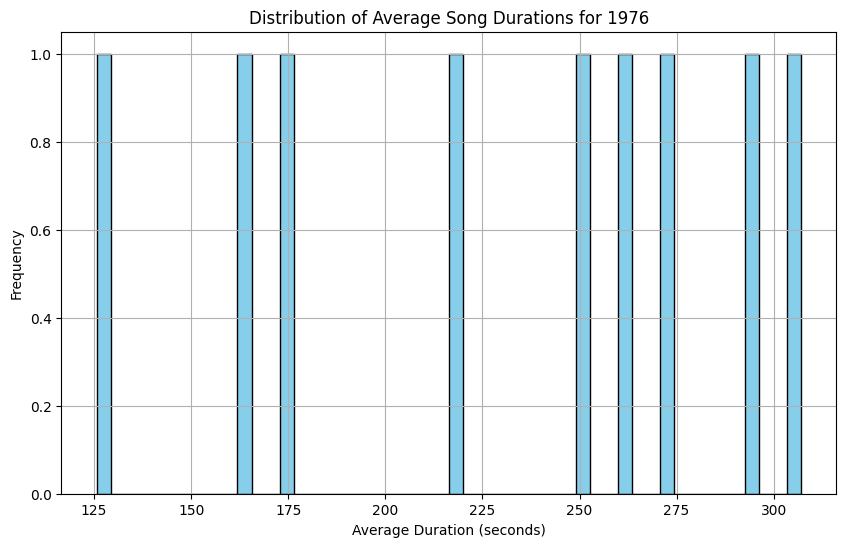

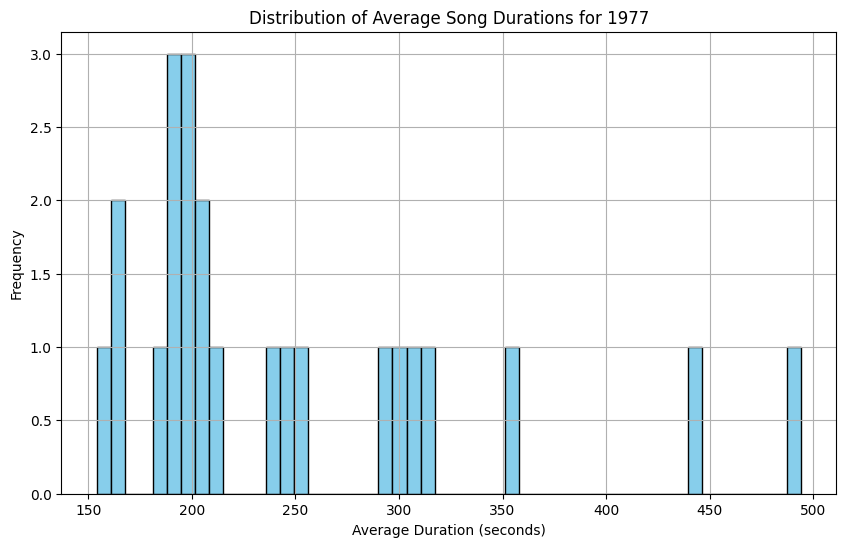

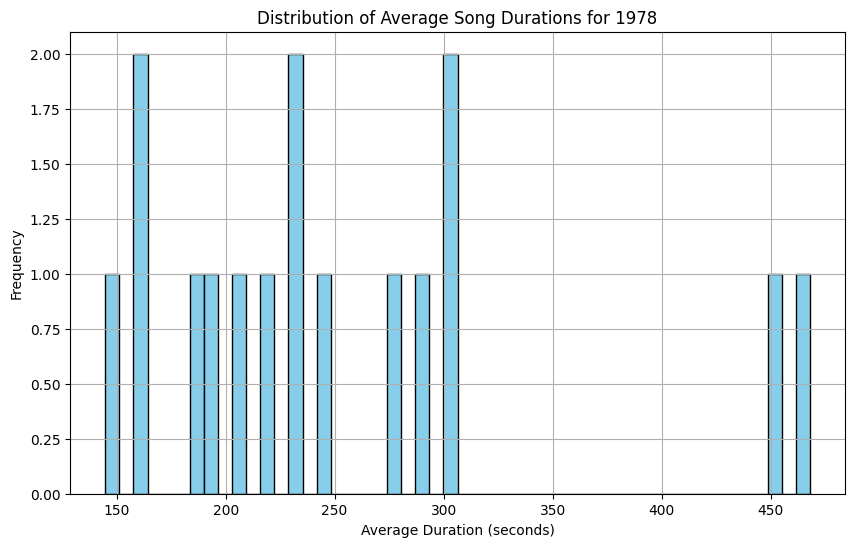

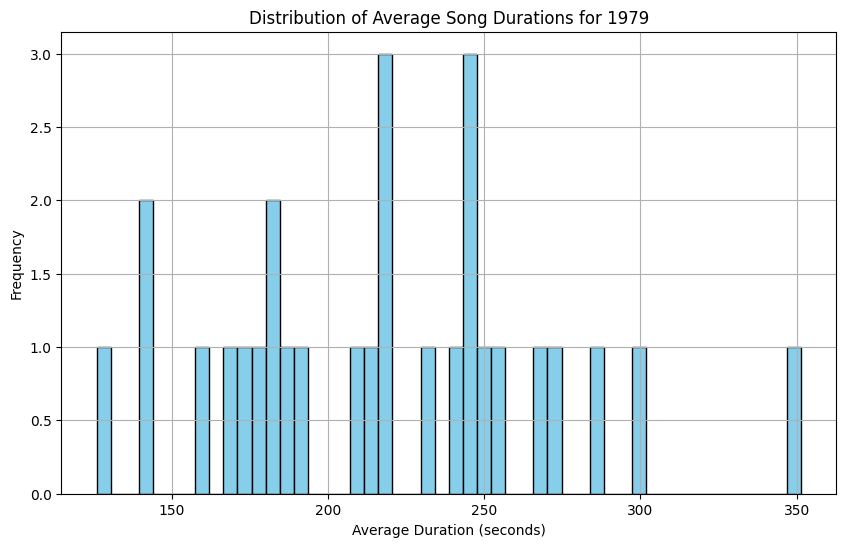

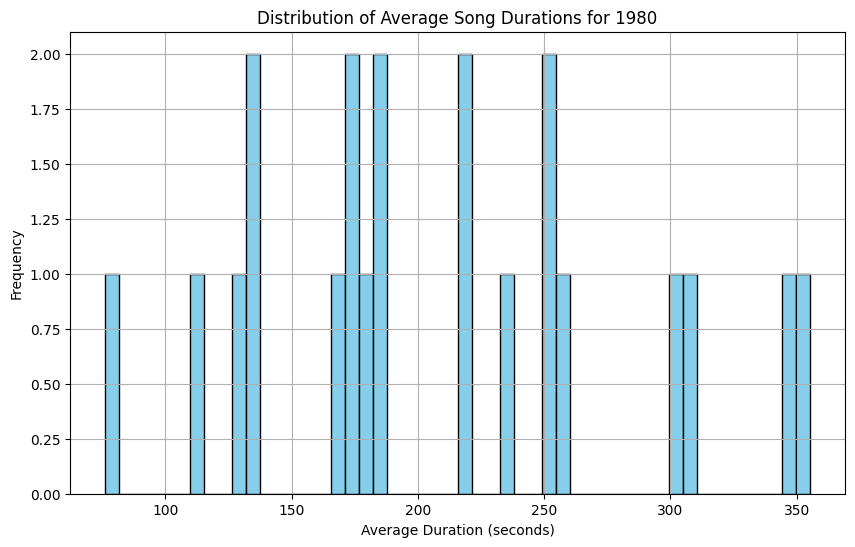

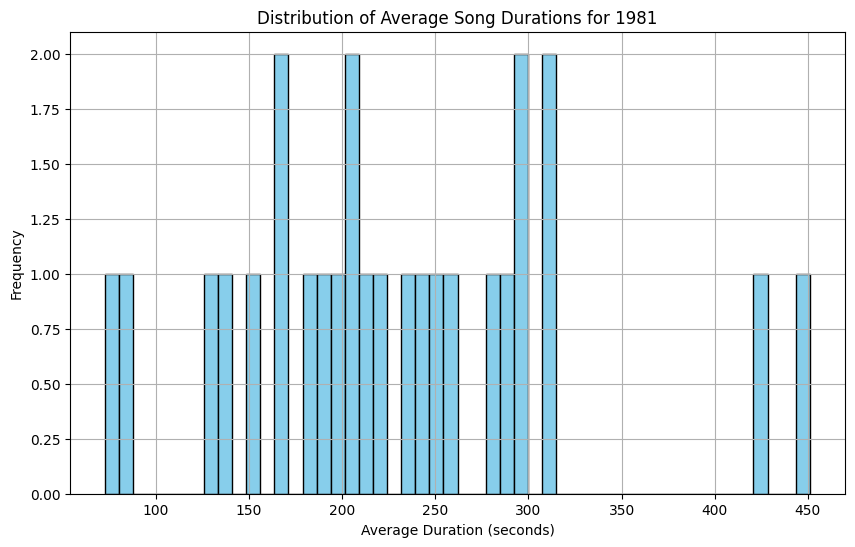

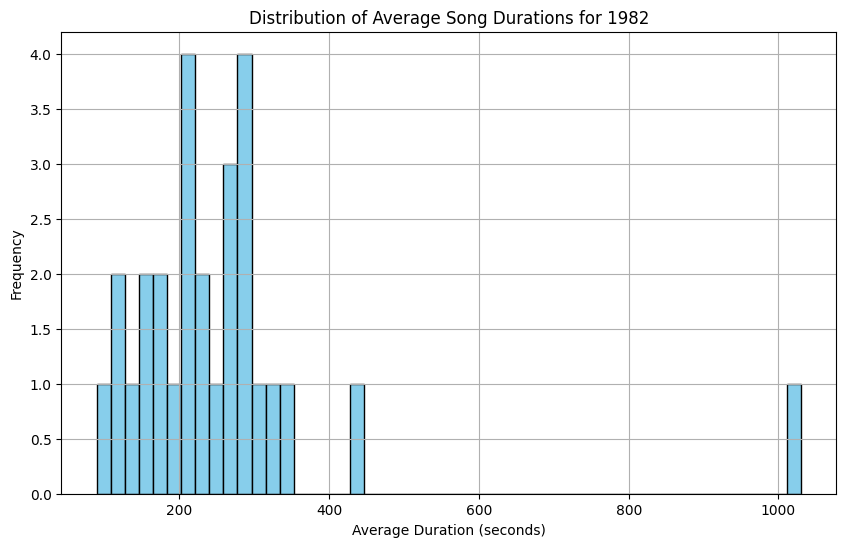

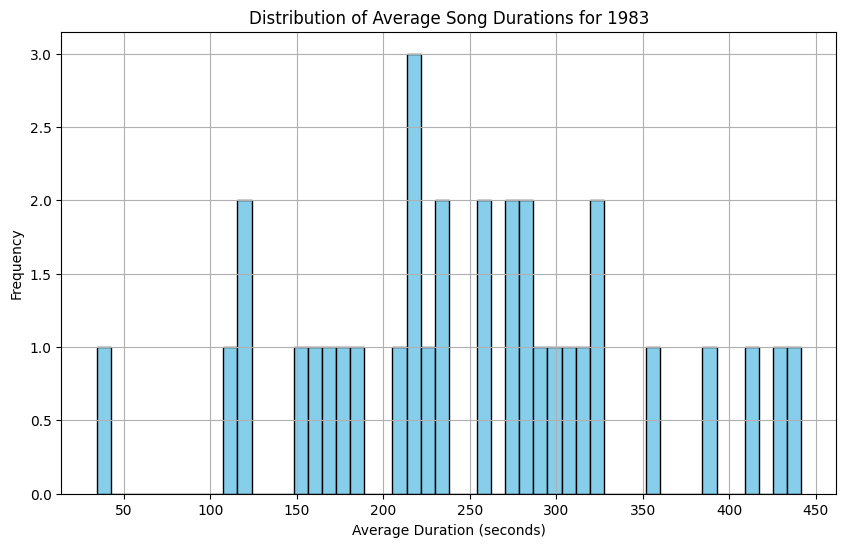

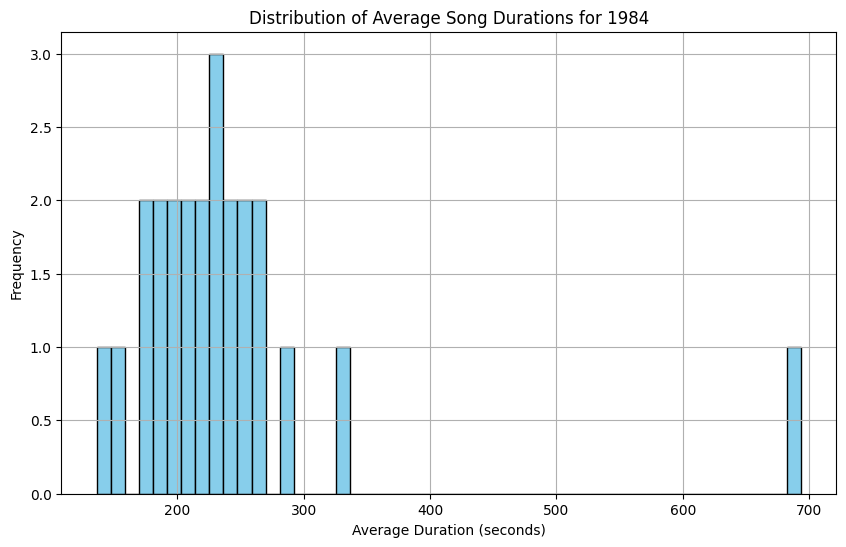

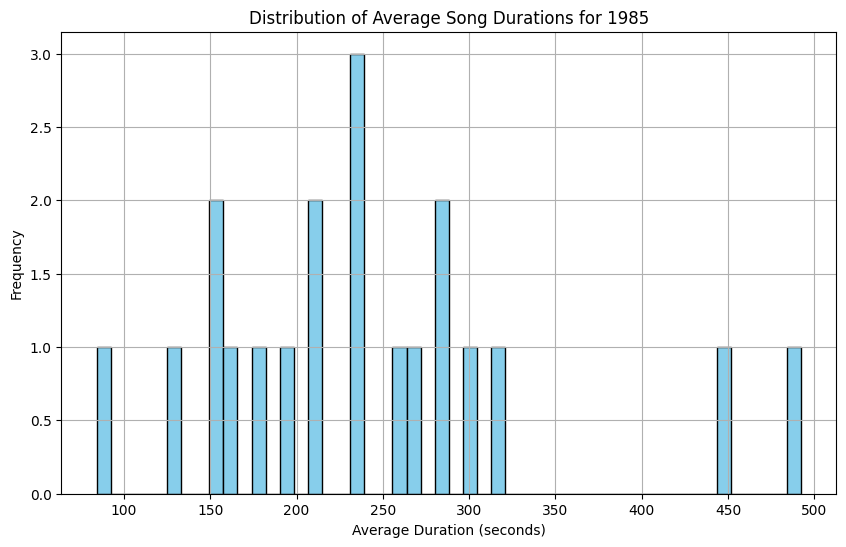

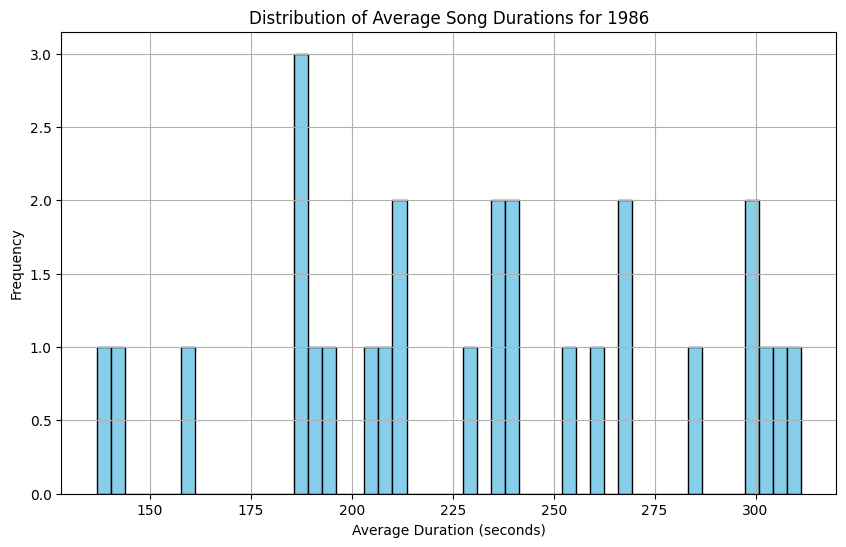

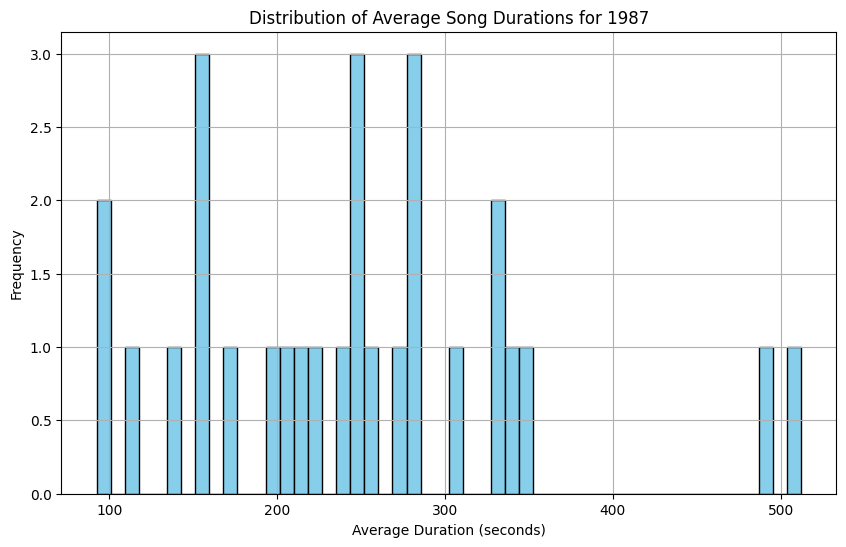

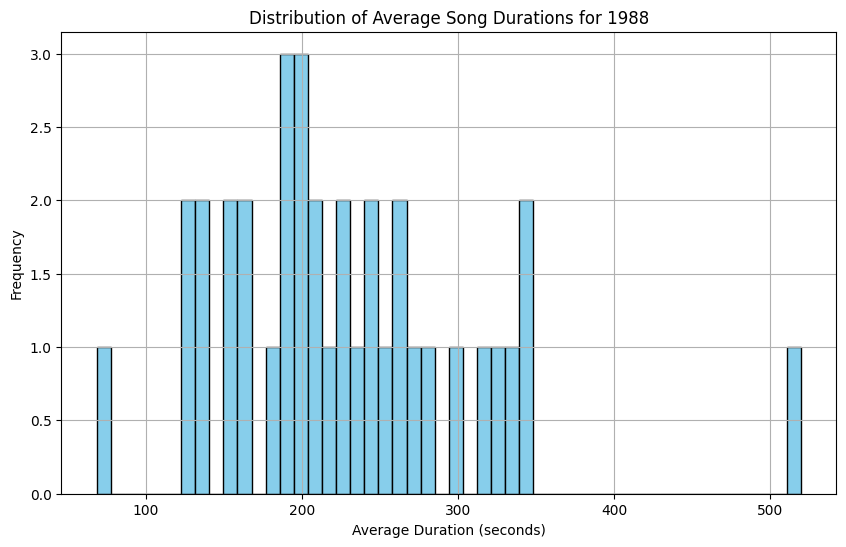

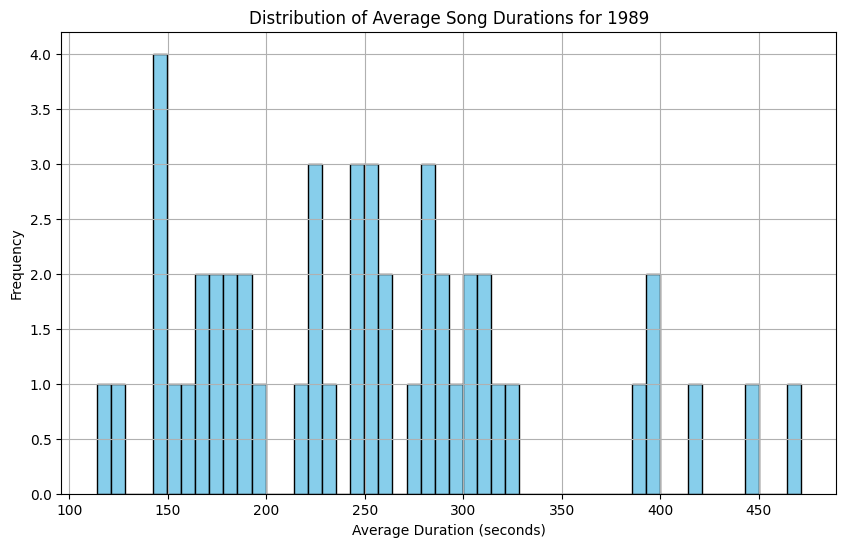

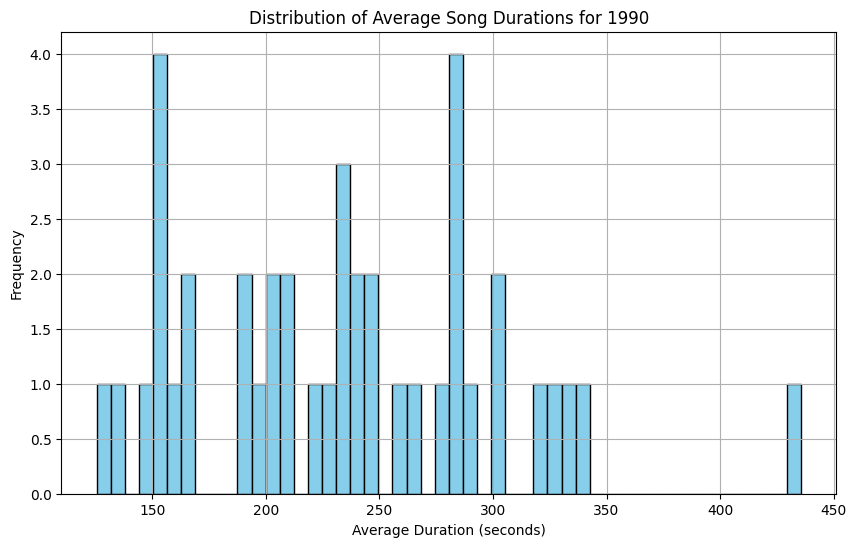

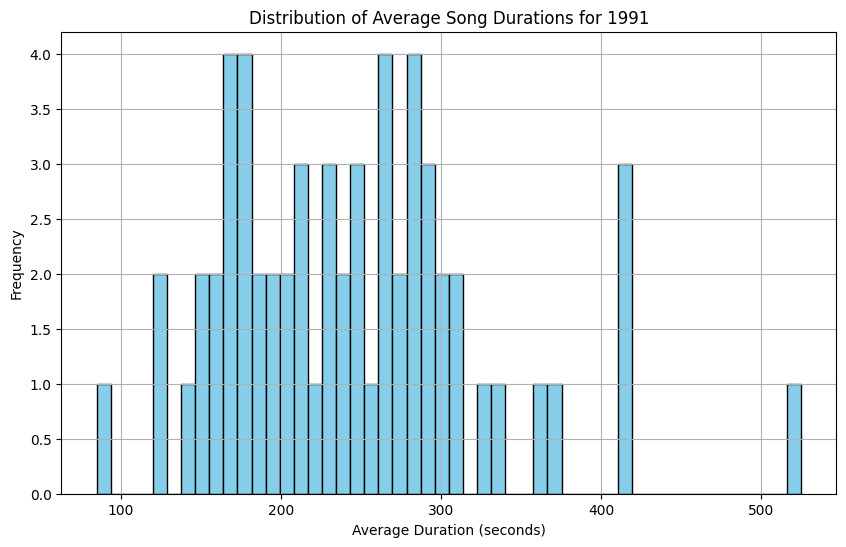

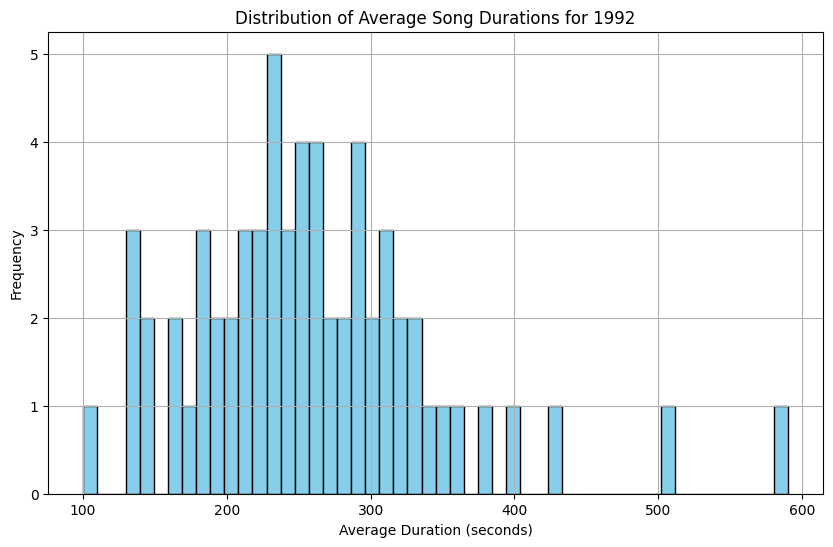

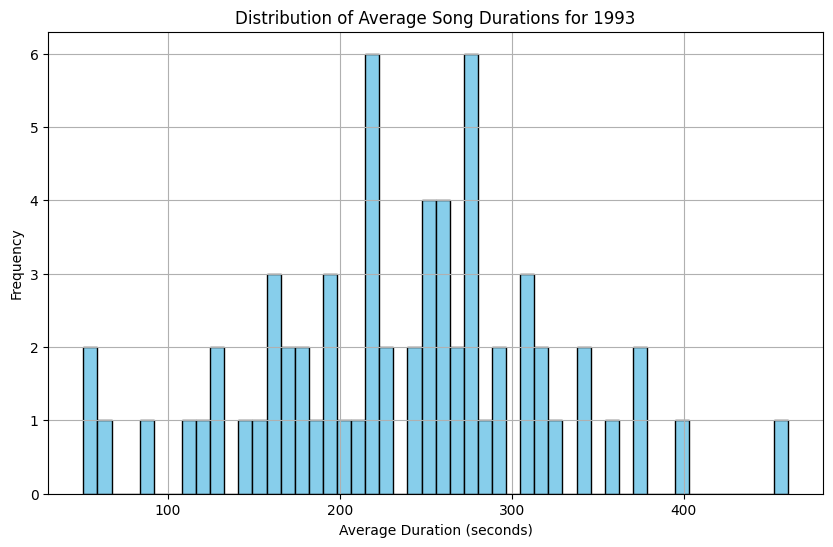

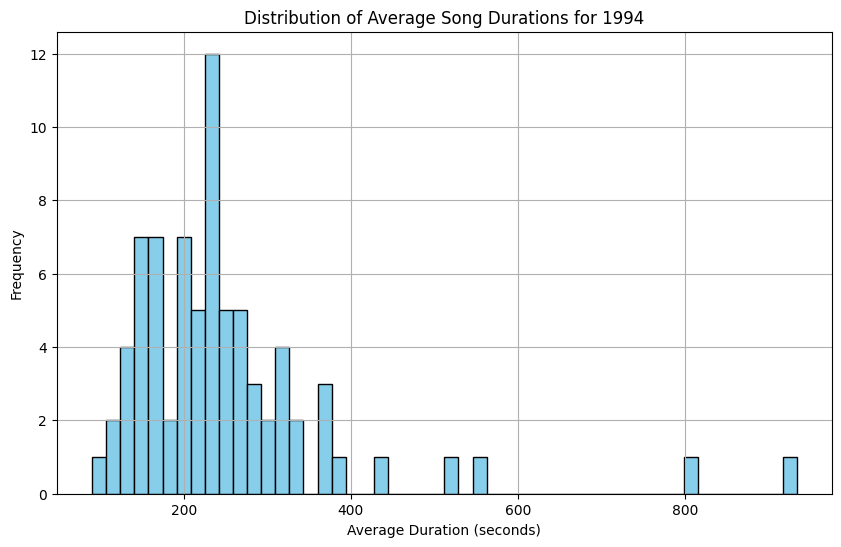

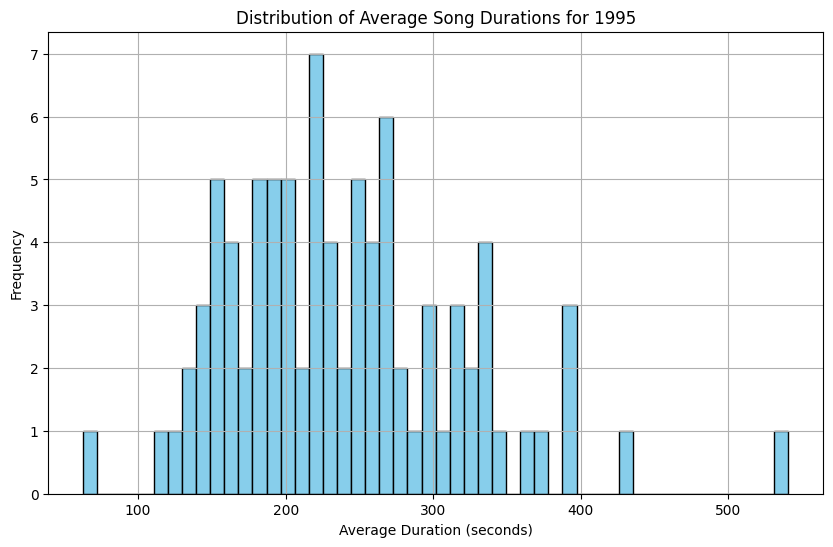

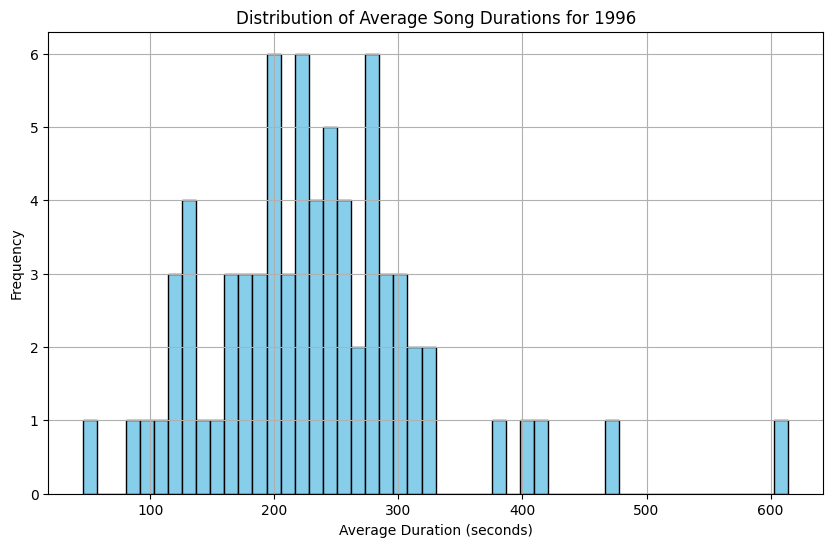

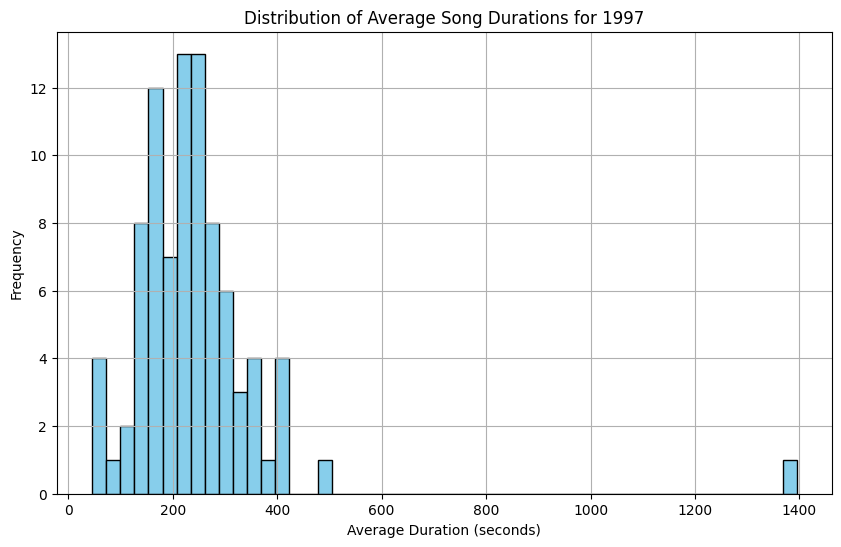

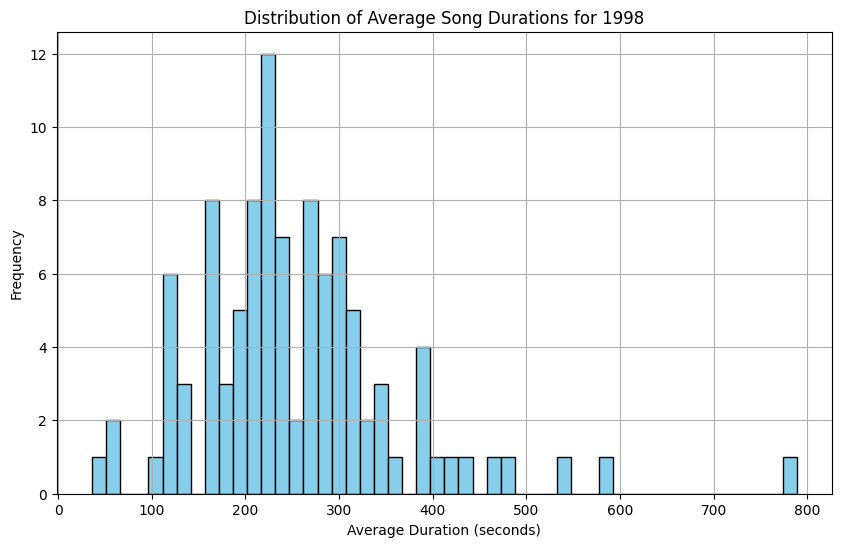

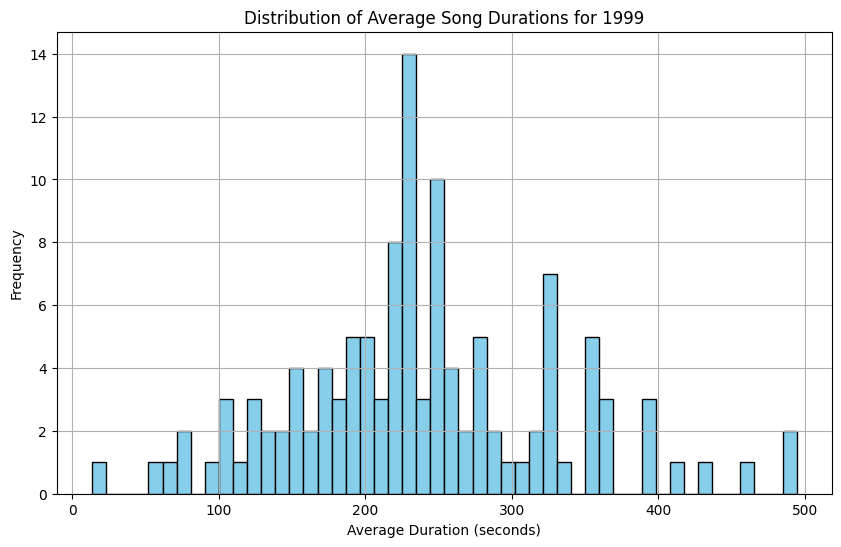

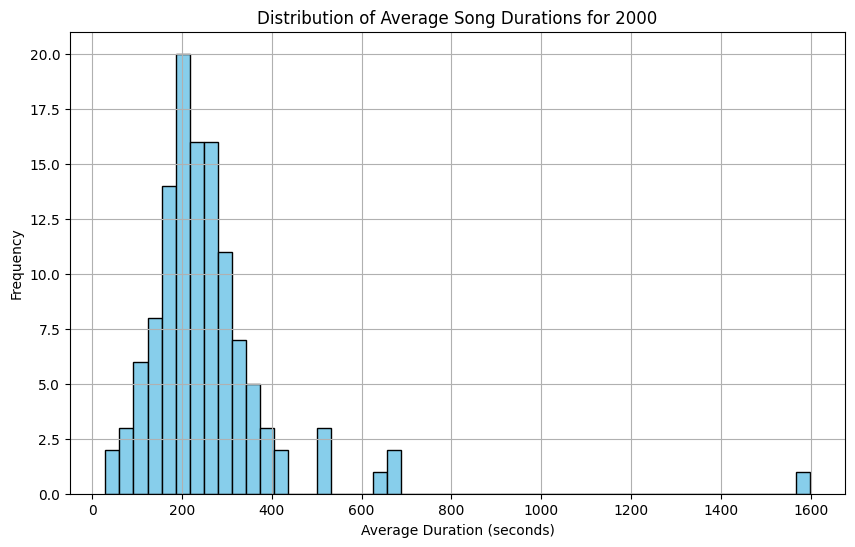

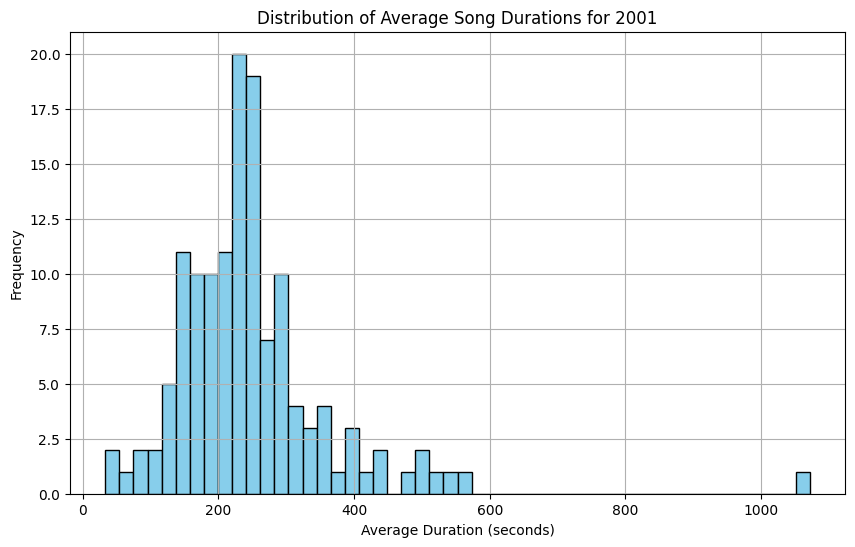

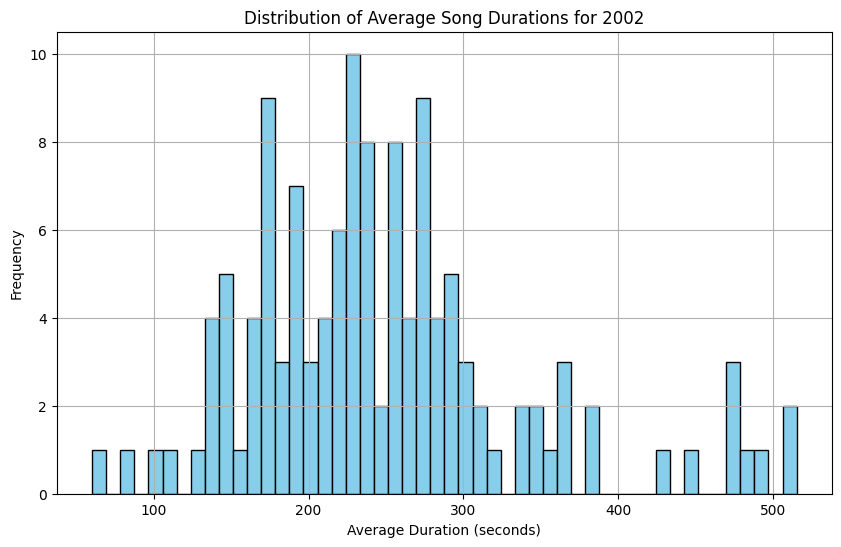

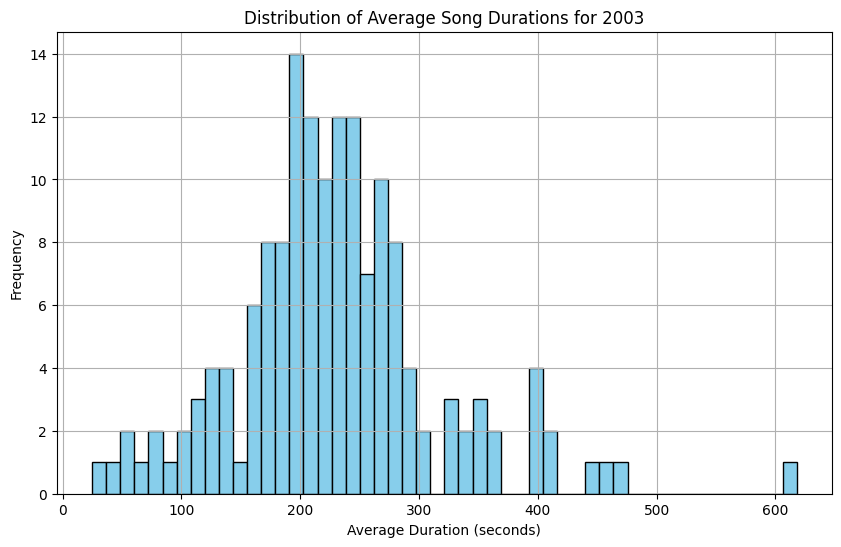

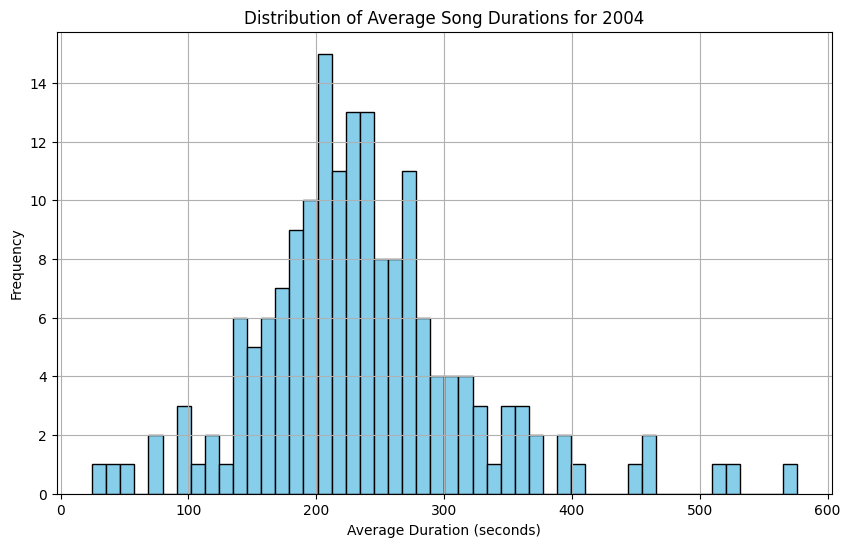

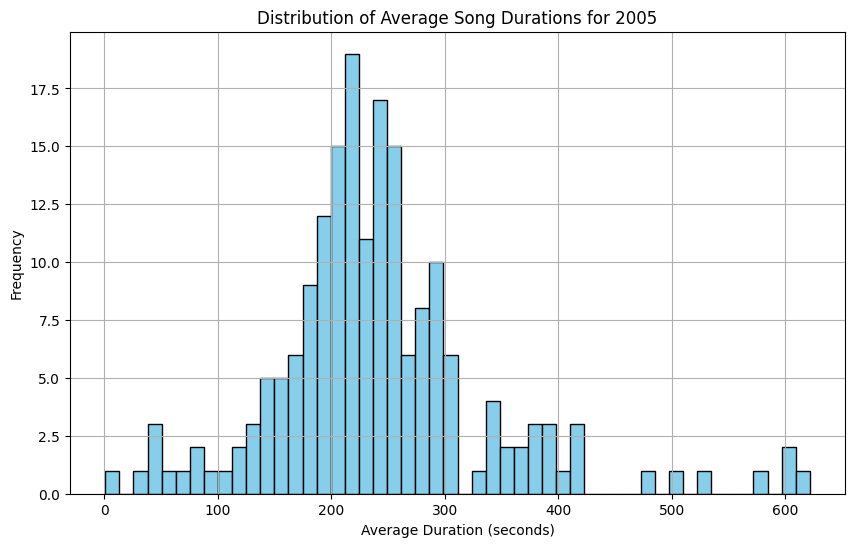

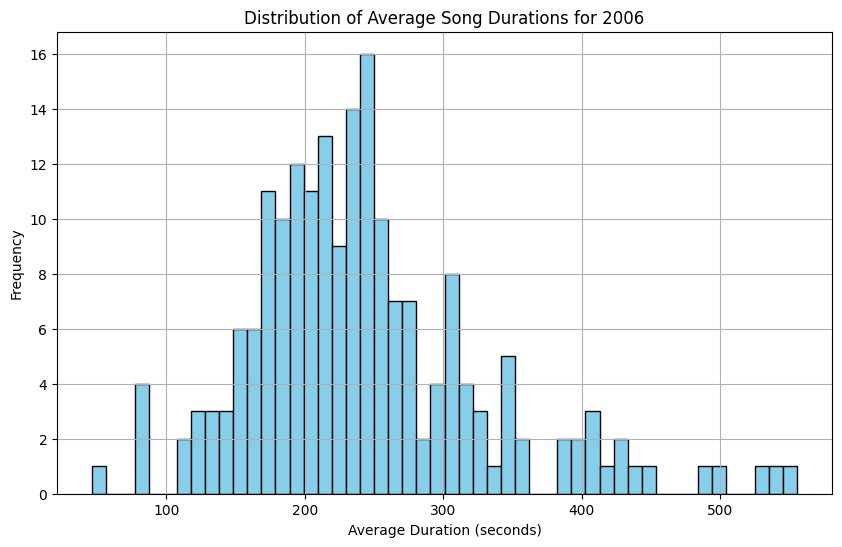

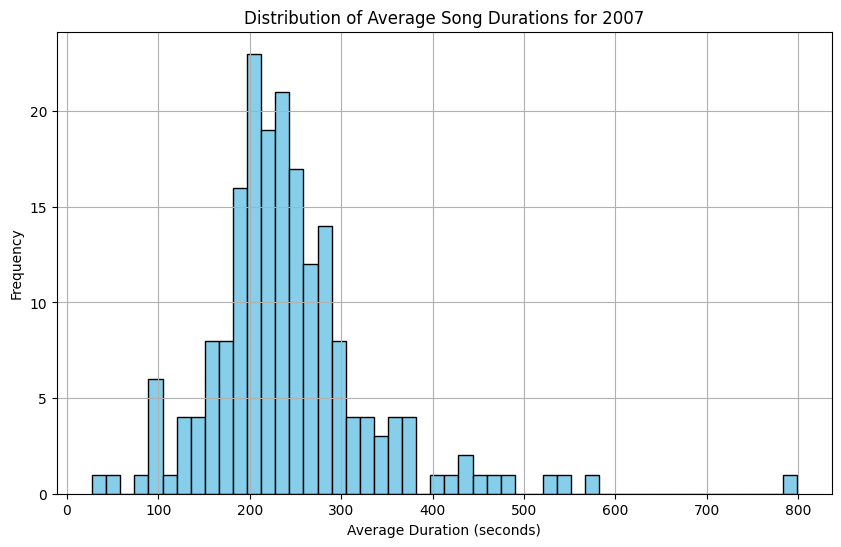

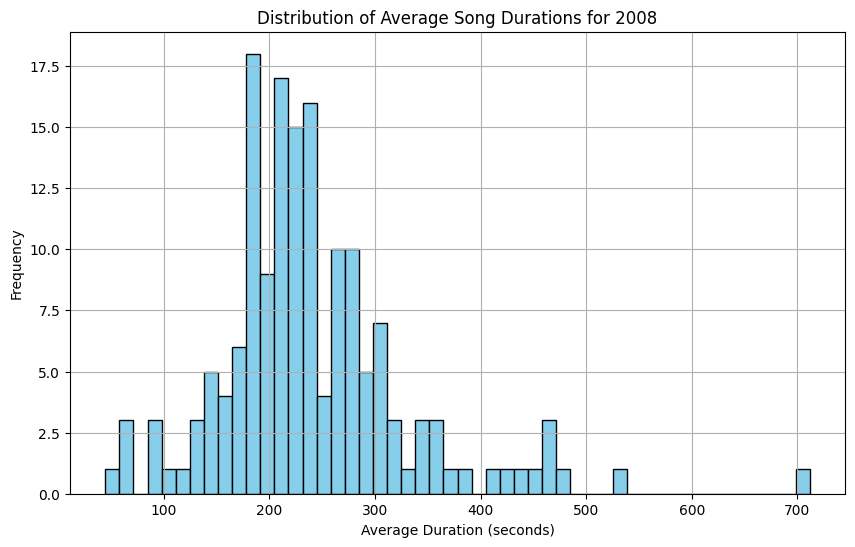

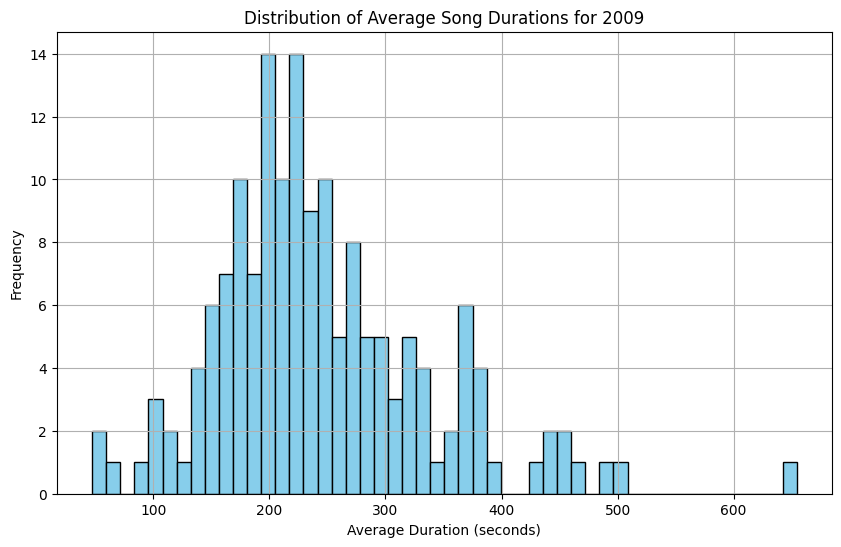

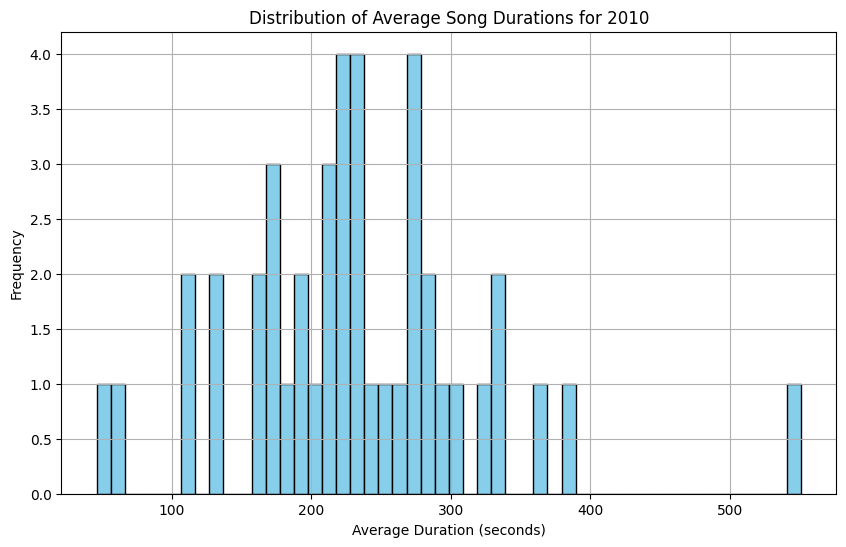

Execution time: 47.28554153442383 seconds


In [9]:
import time
import matplotlib.pyplot as plt

# Start timing
start_time = time.time()

# Assuming your RDD contains rows in the format (Track Id, Artist, Title, Year, Hotness, Duration, Album Name, Album ID)
# Filter out the header row
header = rdd.first()
rdd = rdd.filter(lambda line: line != header)

# Split each line by comma and map to ((Artist, Year), (Duration, 1)) tuple
artist_year_duration_rdd = rdd.map(lambda line: line.split(",")).map(lambda x: ((x[1], int(x[3])), (float(x[5]), 1)))

# Reduce by key to sum up durations and count the number of songs per artist per year
artist_year_sum_count_rdd = artist_year_duration_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculate average duration for each artist per year
artist_year_avg_duration_rdd = artist_year_sum_count_rdd.mapValues(lambda x: x[0] / x[1])

# Collect the result
result = artist_year_avg_duration_rdd.collect()

# Extract data for plotting
years = sorted(list(set([item[0][1] for item in result])))  # Get unique years and sort them
for year in years:
    avg_durations = [item[1] for item in result if item[0][1] == year]

    # Plot the histogram for the current year
    plt.figure(figsize=(10, 6))
    plt.hist(avg_durations, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Average Duration (seconds)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Average Song Durations for {year}')
    plt.grid(True)
    plt.savefig(f'song_average_{year}.png')
    plt.show()

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


